In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import scipy as sp
import scipy.stats as sps
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import gc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re

import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt
from numpy.linalg import inv
from numpy import linalg as LA
from scipy.linalg import eigvals as eig
import seaborn as sns
from collections import Counter
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import tqdm_notebook
import gc
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from scipy.linalg import eigvals

sns.set()
%matplotlib inline

## Подготовка Таблицы

In [2]:
df = pd.read_csv("201", sep = "\t")
df.drop(columns = ["payment_type"], inplace = True)
df["event_time"] =  pd.to_datetime(df["event_time"])
df = df.sort_values(by=['event_time'])
df["real_consumption"] =pd.to_numeric(df["real_consumption"])
dummy = pd.get_dummies(df["event"])
dummy.drop(columns = ["ba_became_paid", "ba_created", "cloud_created", "day_use", \
                      "first_paid_consumption", "first_payment", "first_trial_consumption"], inplace = True)
df = pd.concat([df, dummy], axis = 1)

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sku = pd.read_csv("sku_tags.csv")
sku.drop(columns = ["service_name", "sku_id"], inplace = True)

services = ['compute', 'network', 'storage', 'managed_databases',
            'container_registry', 'artificial_intelligence',
            'network_load_balancer', 'yandex_message_queue']

subservices_hash_map = {}
for service in services:
    subservices = sku[sku["service_long_name"] == service]["subservice_name"].unique()
    subservices = ["subservice_" + col for col in subservices]
    subservices_hash_map[service] = subservices

In [4]:
core_cols = ['core_5.0', 'core_fraction_10.0', 'core_fraction_20.0', 'core_fraction_50.0', \
             'core_100.0']
platform_cols = ['platform_v1', 'platform_v2']
database_cols = ['clickhouse', 'mongo', 'ms_sql', 'mysql', 'pg', 'redis']
preemtible_col = ['preemtible_is']

In [5]:
sku = pd.read_csv("sku_tags.csv")
sku.drop(columns = ["service_name", "sku_id"], inplace = True)

dummy = pd.get_dummies(sku["core_fraction"])
dummy.columns = ["core_" + str(i) for i in dummy.columns]
sku = pd.concat([sku, dummy], axis = 1)
sku.drop(columns = ["core_fraction"], inplace = True)

dummy = pd.get_dummies(sku["database"])
dummy.columns = ["database_" + str(i) for i in dummy.columns]
sku = pd.concat([sku, dummy], axis = 1)
sku.drop(columns = ["database"], inplace = True)

dummy = pd.get_dummies(sku["platform"])
dummy.columns = ["platform_" + str(i) for i in dummy.columns]
sku = pd.concat([sku, dummy], axis = 1)
sku.drop(columns = ["platform"], inplace = True)

dummy = pd.get_dummies(sku["preemptible"])
dummy.columns = ["preemtible_is"]
sku = pd.concat([sku, dummy], axis = 1)
sku.drop(columns = ["preemptible"], inplace = True)

dummy = pd.get_dummies(sku["service_long_name"])
sku = pd.concat([sku, dummy], axis = 1)

dummy = pd.get_dummies(sku["subservice_name"])
dummy.columns = ["subservice_" + str(i) for i in dummy.columns]
sku = pd.concat([sku, dummy], axis = 1)
#sku.drop(columns = ["subservice_name"], inplace = True)


In [6]:
df = df.merge(sku, left_on='sku_name', right_on = "sku_name", how = "left")
df.drop(columns = ["sku_name"], inplace = True)

In [7]:
df.head()

,event_time,puid,billing_account_id,event,trial_consumption,trial_consumption_cum,first_first_paid_consumption_datetime,real_consumption,real_consumption_cum,ba_currency,...,subservice_ram,subservice_redis,subservice_snapshot,subservice_speech,subservice_std,subservice_storage,subservice_used_space,subservice_vision,subservice_windows,subservice_ymq
0,2018-09-25 23:59:58,730781156,dn2ogip1eaf2aoq5l1p6,first_paid_consumption,0.000000,0.000000,2018-09-25 23:59:58,0.000000,0.000000,RUB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-09-25 23:59:59,730265970,dn28dkl723sqjff6g5ce,day_use,-0.000000,0.000000,2018-09-25 23:59:58,0.000495,0.000000,RUB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-09-25 23:59:59,730781156,dn2ogip1eaf2aoq5l1p6,day_use,-0.000000,0.000000,2018-09-25 23:59:58,0.000000,0.000000,RUB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-09-25 23:59:59,730265970,dn28dkl723sqjff6g5ce,day_use,-0.000000,0.000000,2018-09-25 23:59:58,0.000000,0.000000,RUB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-09-25 23:59:59,730265970,dn28dkl723sqjff6g5ce,day_use,2.024575,2.024575,2018-09-25 23:59:58,14.275525,14.275525,RUB,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.shape

(722475, 92)

-----------

# Общее

In [9]:
class Client:
    def __init__(self, puid, acc_num, ba_currency, ba_person_type, segment,
                 ba_payment_cycle_type, service_long_name):
        self.id = puid
        self.payed_acc_num = acc_num
        self.ba_currency = ba_currency
        self.ba_person_type = ba_person_type
        self.segment = segment
        self.ba_payment_cycle_type = ba_payment_cycle_type
        self.service_long_name = service_long_name
        self.out_of_cloud = False
        self.weeks_in_cloud = -1
        
    def print_info(self):
        print("Client INFO\n==================================")
        print("puid:", self.id)
        print("payed_acc_num:", self.payed_acc_num)
        print("ba_currency:", self.ba_currency)
        print("ba_person_type:", self.ba_person_type)
        print("segment:", self.segment)
        print("ba_payment_cycle_type:", self.ba_payment_cycle_type)
        print("service_long_name:", self.service_long_name)
        print("out_of_cloud:", self.out_of_cloud)
        print("weeks_in_cloud:", self.weeks_in_cloud)
        print("==================================")

In [10]:
def calculate_client_info(curr_sku, df_curr): #Посчитать для каждого юзера общую инфу в классе Client, кроме раве что, 
                                              #out_of_cloud, weeks_in_cloud
    df = df_curr[df_curr["service_long_name"] == curr_sku]
    puids = df["puid"].unique()
    #всего юзеров на данном сервисе
    print("Common info\n====================")
    print("unique users:", df["puid"].unique().shape)
    print("====================")
    df_grouped = df_curr.groupby(["puid"])
    hashed_clients = {}
    for puid, df_account in df_grouped:
        
        if puid not in puids:
            continue
        df_account = df_account[(df_account["service_long_name"] == curr_sku) |
                                (df_account["event"] != "day_use")]
        
        if df_account["ba_currency"].unique().shape[0] > 1:
            print(df_account["ba_currency"].unique())

        acc_num = df_account["billing_account_id"].unique().shape[0]
        ba_currency = df_account["ba_currency"].unique()[0]
        ba_person_type = np.array(df_account["ba_person_type"].unique())
        ba_person_type = ba_person_type[~pd.isnull(ba_person_type)]

        if ba_person_type.shape[0] > 1: 
            #print(df_account.head())
            #print(bill_id, df_account["ba_person_type"].unique())
            ba_person_type = np.array(['company'])

        if ba_person_type.shape[0] == 0:
            ba_person_type = np.array(['no_type'])

        segment = np.array(df_account["segment"].unique())
        if segment.shape[0] > 1: 
            #print(bill_id, df_account["segment"].unique())
            segment = [df_account["segment"].iloc[-1]]

        ba_payment_cycle_type = np.array(df_account["ba_payment_cycle_type"].unique())
        if ba_payment_cycle_type.shape[0] > 1: 
            #print(bill_id, df_account["segment"].unique())
            ba_payment_cycle_type = [df_account["ba_payment_cycle_type"].iloc[-1]]
            print(ba_payment_cycle_type)

        service_long_name = np.array(df_curr[df_curr["puid"] == puid]["service_long_name"].unique())
        service_long_name = service_long_name[~pd.isnull(service_long_name)]
        #print(bill_id, ba_currency, ba_person_type, segment,
         #            ba_payment_cycle_type, service_long_name)
        hashed_clients[puid] = Client(puid, acc_num, ba_currency, ba_person_type[0], segment[0],
                     ba_payment_cycle_type[0], service_long_name)

    print("OK")
    return hashed_clients

In [11]:
def make_simple_analysis(curr_sku, df_curr):
    df = df_curr[df_curr["service_long_name"] == curr_sku]
    curr = df.groupby([pd.Grouper(key='event_time', freq='W-Mon')])['real_consumption'].sum()\
                                .reset_index().sort_values('event_time')
    curr = curr[curr["event_time"] <= last_date_of_observing]
    plt.figure(figsize = (10, 7))
    plt.title("Real consumption в неделю для {}".format(curr_sku), fontsize = 15)
    plt.plot(curr["event_time"], curr["real_consumption"], color = "orange")
    plt.xlabel("дата", fontsize = 15)
    plt.ylabel("Real consumption", fontsize = 15)

In [12]:
add_hash_map = {}
add_hash_map["core_fraction"] = ['core_5.0', 'core_10.0', 'core_20.0', 'core_50.0', 'core_100.0']
add_hash_map["platform"] = ['platform_v1', 'platform_v2']
add_hash_map["database"] = ['database_clickhouse', 'database_mongo', 'database_ms_sql', 
                            'database_mysql', 'database_pg', 'database_redis']
add_hash_map["preemptible"] = ['preemtible_is']

In [13]:
services = ['compute', 'network', 'storage', 'managed_databases',
            'container_registry', 'artificial_intelligence',
            'network_load_balancer', 'yandex_message_queue']

In [14]:
#Возвращает необходимые столбцы для каждого сервиса автоматически
def prepare_service_sku_columns(curr_sku):
    sku = pd.read_csv("sku_tags.csv")
    sku.drop(columns = ["service_name", "sku_id"], inplace = True)
    add_cols = ["core_fraction", "database", "platform", "preemptible"]
    ans = []
    for col in add_cols:
        vals = np.array(sku[sku["service_long_name"] == curr_sku][col].unique())
        vals = vals[~pd.isnull(vals)]
        if vals.shape[0] != 0:
            for new_col in add_hash_map[col]:
                ans.append(new_col)
    for new_col in subservices_hash_map[curr_sku]:
        ans.append(new_col)
    return ans

## Compute

In [15]:
compute_curr_sku = "compute"

Подсчет общей информации про клиента. (out_of_cloud и weeks_in_cloud - не обращать внимания)

In [16]:
compute_hashed_clients = calculate_client_info(compute_curr_sku, df)

Common info
unique users: (2638,)
OK


In [17]:
services

['compute',
 'network',
 'storage',
 'managed_databases',
 'container_registry',
 'artificial_intelligence',
 'network_load_balancer',
 'yandex_message_queue']

In [18]:
last_date_of_outing = np.datetime64('2019-06-01')

last_date_of_observing = np.datetime64('2019-07-01')

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


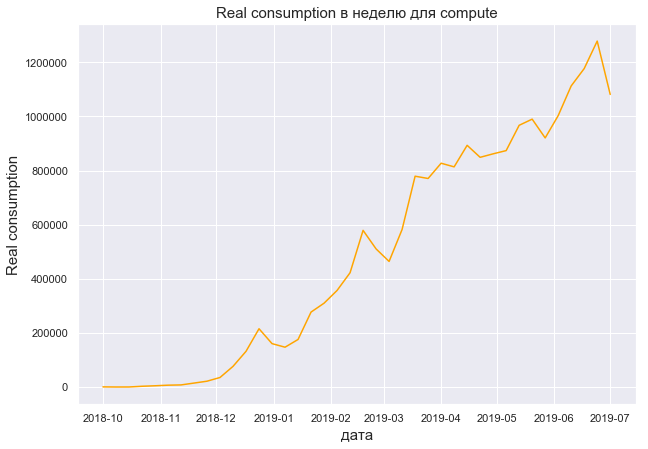

In [19]:
make_simple_analysis(compute_curr_sku, df)

In [20]:
compute_cols = prepare_service_sku_columns("compute")

In [21]:
df.columns

Index(['event_time', 'puid', 'billing_account_id', 'event',
       'trial_consumption', 'trial_consumption_cum',
       'first_first_paid_consumption_datetime', 'real_consumption',
       'real_consumption_cum', 'ba_currency', 'ba_payment_cycle_type',
       'ba_person_type', 'ba_state', 'segment', 'call', 'click_mail', 'visit',
       'service_long_name', 'subservice_name', 'core_5.0', 'core_10.0',
       'core_20.0', 'core_50.0', 'core_100.0', 'database_clickhouse',
       'database_mongo', 'database_ms_sql', 'database_mysql', 'database_pg',
       'database_redis', 'platform_v1', 'platform_v2', 'preemtible_is',
       'artificial_intelligence', 'compute', 'container_registry',
       'managed_databases', 'marketplace', 'network', 'network_load_balancer',
       'storage', 'yandex_message_queue', 'subservice_active',
       'subservice_allocated', 'subservice_clickhouse', 'subservice_cpu',
       'subservice_dataproc', 'subservice_delete',
       'subservice_egress_cross_dc', 'subser

### Создание наиболее важной таблицы

Есть много лишней инфы, но я готовил эту таблицу к предсказанию оттока, но лишь некоторая ее часть нужна для кластеризациии (Возможно понадобится в будущем). В таблице останутся только те пользователи, которые 29 дней были в сервисе, и реально потребляли сервис. В ней не учтено потребление клиентом на простое хранение (То есть записей с типами nbs.network-hdd.allocated и nbs.network-nvme.allocated тут нет).

In [22]:
def prepare_columns_inside_table_creator(add_cols): # Подготовка столбцов для таблицы и словаря для группировки 
                                                    # по доп столбцам
    person_cols = ["puid", "out_of_cloud", "ba_person_type", "segment", \
                   "ba_payment_cycle_type", \
                   "avg_day_consumption", "max_day_consumption", "non_zero_days_consumption",\
                   "visits", "clicks", "calls"]
    val = "sum"
    add_dict = {}
    for col in add_cols:
        add_dict[col] = val
        person_cols.append("avg_" + col)
        person_cols.append("max_" + col)
        person_cols.append("non_zero_days_" + col)
    for service in services:
        person_cols.append("consumption_service_" + service)

    for i in range(4, 0, -1):
        person_cols.append("real_consumption_" + str(-i))
    return person_cols, add_dict


#Получаем сгруппированную инфу 
def raw_info_getter(curr_sku, puid, df_account, hashed_clients, add_cols):
    
    curr_cons = df_account.groupby([pd.Grouper(key='event_time', freq = "d")]).agg({
        'real_consumption':"sum"
    }).reset_index().sort_values('event_time')     
    
    additional_consump = {}
    
    for col in add_cols:
        curr_add_df = df_account[df_account[col] > 0.1]
        #print(curr_add_df)
        add_df_temp = curr_add_df.groupby([pd.Grouper(key='event_time', freq = "d")]).agg(\
         {'real_consumption':"sum"}).reset_index().sort_values('event_time')
        additional_consump[col] = np.array(add_df_temp["real_consumption"])

    consumptions = np.array(curr_cons['real_consumption'])
    clicks = df_account['click_mail'].sum()
    visits = df_account['visit'].sum()
    calls = df_account['call'].sum()
    return consumptions, clicks, visits, calls, additional_consump

#Делаем нужные столбцы численными
def last_preparation_table_inside_table_creator(person_df):
    
    person_df["puid"] = pd.to_numeric(person_df["puid"])
    person_df["out_of_cloud"] = pd.to_numeric(person_df["out_of_cloud"])
    
    patterns = ["num_", "clicks", "non_zero_days_", \
                "calls", "visits", "max_", "avg_", "consumption_", "real_consumption"]
    type_cols = [i for i in person_df.columns if any(x in i for x in patterns)]
    for col in type_cols:
        person_df[col] = pd.to_numeric(person_df[col])
    return person_df

#Сгруппированное добавление в строку
def adding_person_mean_max_non_zero_info(person_row, arr):
    if np.count_nonzero(arr) == 0:
        person_row.append(0)
    else:
        person_row.append(np.sum(arr) / np.count_nonzero(arr))
    person_row.append(np.max(arr))
    person_row.append(np.count_nonzero(arr))

#Создание строки для таблицы
def person_row_creator(
                       puid,
                       out_of_cloud, 
                       ba_person_type, 
                       segment, 
                       ba_payment_cycle_type, 
                       consumptions,
                       visits,
                       clicks,
                       calls,
                       add_cols,
                       additional_consump):
    person_row = [puid, out_of_cloud, ba_person_type, segment, 
                  ba_payment_cycle_type]

    adding_person_mean_max_non_zero_info(person_row, consumptions)
    person_row.append(visits)
    person_row.append(clicks)
    person_row.append(calls)

    for col in add_cols:
        if additional_consump[col].shape[0] == 0:
            person_row.append(0)
            person_row.append(0)
            person_row.append(0)
            continue
        adding_person_mean_max_non_zero_info(person_row, additional_consump[col])
    return person_row

In [23]:
#last_date_of_observing - максимальная дата ограничения, если клиент будет неактивным, 
#то 30 дней до этой даты не потреблял сервис
def person_table_creator(curr_sku, df_curr, hashed_clients, add_cols, last_date_of_observing):
    person_cols, add_dict = prepare_columns_inside_table_creator(add_cols)
    count = 1
    person_count = 1
    dropped_users = 0
    person_df = pd.DataFrame(columns = person_cols)
    df = df_curr[df_curr["service_long_name"] == curr_sku]
    puids = df["puid"].unique()
    print("Common info\n====================")
    print("unique users:", puids.shape[0])
    print("====================")
    df_grouped = df_curr.groupby(["puid"])
    plt.figure(figsize = (10, 7))
    for puid, df_account in tqdm(df_grouped):
    
        if puid not in puids:
            continue
        
        # Берем только нужные записи из таблицы
        df_account = df_account[(df_account["service_long_name"] == curr_sku)|
                                (df_account["event"] != "day_use")]
        
        #ограничим просмотром только на следующий месяц
        df_account = df_account[df_account['event_time'] <= last_date_of_observing]
        if df_account[df_account['real_consumption'] >= 0.1].shape[0] == 0: #не было вообще потребления
            continue
        
        last_dt = df_account[df_account['real_consumption'] >= 0.1]["event_time"].iloc[-1]
        
        dropped = False
        # Если в последний раз потребление было ранее 30 дней до последней даты, то он ушел, иначе остался
        #(при этом ограничились просмоторм макс след месяцем)
        if  last_dt < last_date_of_observing - pd.Timedelta(30, unit='d'):
            dropped = True
        
        # Теперь смотрим только на информацию по 30 последним активным дням
        min_dt = last_dt - pd.Timedelta(30, unit='d')
        df_account = df_account[(df_account['event_time'] <= last_dt)]        
        df_account = df_account[(df_account['event_time'] >= min_dt)]
        
        #посчитаем метрики по дням
        consumptions, clicks, \
        visits, calls, additional_consump = raw_info_getter(curr_sku, puid, 
                                                                     df_account, hashed_clients, add_cols)
        
        curr_client = hashed_clients[puid]
        
        #Должен быть в сервисе хотя бы 29 дней, где последний не учитываем, он в течение него мог уйти
        last_days = 29
        if consumptions.shape[0] < 29:
            continue
    
        
########################Создание строки##################################
        person_row = person_row_creator( puid,
                       dropped, 
                       curr_client.ba_person_type, 
                       curr_client.segment, 
                       curr_client.ba_payment_cycle_type, 
                       consumptions,
                       visits,
                       clicks,
                       calls,
                       add_cols,
                       additional_consump)
        for service in services:
            
            curr_cons = df_curr[(df_curr["puid"] == puid) &\
                    (df_curr["service_long_name"] == service)]["real_consumption"].sum()
            person_row.append(curr_cons)
        
        curr_cons = consumptions[-last_days:]
        for i in range(4):
            week_ans = 0
            for j in range(7):
                num = i * 7 + j
                week_ans += curr_cons[num]
            person_row.append(week_ans)
        person_df.loc[person_count] =  person_row
        
        #Считаем общую статистику
        if dropped == True:
            dropped_users += 1
        person_count += 1
########################Конец цикла##################################
        
    person_count -= 1
    person_df = last_preparation_table_inside_table_creator(person_df)
    print("Рассмотрено пользователей:", person_count)
    print("Ушло пользователей:", dropped_users)
    if(person_count != 0):
        print("Процент ушедших пользователей:", dropped_users / person_count)
    
    return person_df

In [24]:
july = np.datetime64('2019-07-01')

In [25]:
compute_person_df = person_table_creator(compute_curr_sku, df,\
                                            compute_hashed_clients, compute_cols, july)

Common info
unique users: 2638



Рассмотрено пользователей: 1066
Ушло пользователей: 160
Процент ушедших пользователей: 0.150093808630394


<Figure size 720x504 with 0 Axes>

In [26]:
compute_person_df.head()

,puid,out_of_cloud,ba_person_type,segment,ba_payment_cycle_type,avg_day_consumption,max_day_consumption,non_zero_days_consumption,visits,clicks,...,consumption_service_storage,consumption_service_managed_databases,consumption_service_container_registry,consumption_service_artificial_intelligence,consumption_service_network_load_balancer,consumption_service_yandex_message_queue,real_consumption_-4,real_consumption_-3,real_consumption_-2,real_consumption_-1
1,10761,False,individual,mass,monthly,10.494358,10.495200,31,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,73.454254,73.452432,73.466401,73.466401
2,18085,False,individual,mass,monthly,207.641450,249.938400,25,22,0,...,248.067314,120.632706,0.0,0.0,0.0,0.0,1728.651076,66.813098,1353.114295,1349.762398
3,77717,True,individual,mass,monthly,110.411189,114.389054,31,14,0,...,0.000888,100.054169,0.0,0.0,0.0,0.0,791.971201,799.612801,706.158562,799.612801
4,217021,False,individual,mass,monthly,10.493284,10.495200,31,0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,73.445265,73.439556,73.454983,73.466401
5,252474,False,individual,isv,monthly,24.259698,24.916800,19,6,0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,87.208800,174.391069,174.417601


In [27]:
compute_person_df[compute_person_df["out_of_cloud"] == 1].shape

(160, 71)

In [28]:
gc.collect()

1968

### Кластеризация

## По дню

Потребление в последние 29 дней.

In [29]:
def raw_info_day_getter(freq, puid, df_account):

    last_dt = df_account[df_account['real_consumption'] >= 0.01]["event_time"].iloc[-1]
    df_account = df_account[df_account['event_time'] <= last_dt]

    curr_common = df_account.groupby([pd.Grouper(key='event_time', freq = freq)]).agg({
        'real_consumption':"sum",
    }).reset_index().sort_values('event_time')     

    consumptions = np.array(curr_common['real_consumption'])
    return consumptions

In [30]:
def day_person_cluster_creator(curr_sku, df_curr, hashed_clients, last_days = 29):
    columns = ["cons_day_-" + str(day) for day in range(-last_days, -1, 1)]
    columns.append("puid")
    columns.append("out_of_cloud")
    count = 1
    day_df = pd.DataFrame(columns = columns)
    df = df_curr[df_curr["service_long_name"] == curr_sku]
    puids = df["puid"].unique()
    df_grouped = df_curr.groupby(["puid"])

    for puid, df_account in tqdm(df_grouped):
    
        #Скопировано из person_table_creator##############################
        if puid not in puids:
                continue
        
        df_account = df_account[((df_account["service_long_name"] == curr_sku) &
                                 (df_account["subservice_name"].isin(["cpu", "ram", "windows", "gpu"])))|
                                (df_account["event"] != "day_use")]
        #ограничим просмотром только на следующий месяц
        df_account = df_account[df_account['event_time'] <= last_date_of_observing]
        if df_account[df_account['real_consumption'] >= 0.1].shape[0] == 0: #не было вообще потребления
            continue
        
        last_dt = df_account[df_account['real_consumption'] >= 0.1]["event_time"].iloc[-1]
        
        dropped = False
        # Если в последний раз потребление было ранее предсказываемого месяца, то он ушел, иначе остался
        #(при этом ограничились просмоторм макс след месяцем)
        if  last_dt < last_date_of_observing - pd.Timedelta(30, unit='d'):
            dropped = True
        
        # Теперь смотрим только на информацию по 30 последним активным дням
        min_dt = last_dt - pd.Timedelta(30, unit='d')
        df_account = df_account[(df_account['event_time'] <= last_dt)]
        
        df_account = df_account[(df_account['event_time'] >= min_dt)]
        
        
        consumptions = raw_info_day_getter("d", puid, df_account)
        
        last_days = 29
        if consumptions.shape[0] < 29:
            continue
        ########################################################################
########################days_creator###################################
        if consumptions.shape[0] < last_days:
            continue
        
        row = []   
        for consumption in consumptions[-last_days:-1]:
            row.append(consumption)
        row.append(int(puid))
        if compute_person_df[compute_person_df["puid"] == puid]["out_of_cloud"].iloc[-1] == 1:
            row.append(1)
        else:
            row.append(0)
        day_df.loc[count] = row
        count += 1
    return day_df

In [31]:
compute_cluster_day_df = day_person_cluster_creator(compute_curr_sku, df, compute_hashed_clients, last_days = 29)

In [32]:
compute_cluster_day_df["out_of_cloud"] = compute_cluster_day_df["out_of_cloud"].astype(int)
compute_cluster_day_df["puid"] = compute_cluster_day_df["puid"].astype(int)

In [33]:
compute_cluster_day_df.head()

,cons_day_--29,cons_day_--28,cons_day_--27,cons_day_--26,cons_day_--25,cons_day_--24,cons_day_--23,cons_day_--22,cons_day_--21,cons_day_--20,...,cons_day_--9,cons_day_--8,cons_day_--7,cons_day_--6,cons_day_--5,cons_day_--4,cons_day_--3,cons_day_--2,puid,out_of_cloud
1,10.4952,10.483053,10.495200,10.495200,10.495200,10.495200,10.495200,10.485968,10.490463,10.495200,...,10.4952,10.4952,10.4952,10.4952,10.4952,10.4952,10.4952,10.4952,10761,0
2,249.9384,249.916049,249.921394,249.915563,249.927103,249.922366,229.110200,0.000000,0.000000,0.000000,...,192.8232,192.8232,192.8232,192.8232,192.8232,192.8232,192.8232,192.8232,18085,0
3,112.3200,112.320000,112.320000,112.320000,114.230400,114.230400,114.230400,114.230400,114.230400,114.230400,...,114.2304,114.2304,114.2304,114.2304,114.2304,114.2304,114.2304,114.2304,77717,1
4,10.4952,10.491920,10.495200,10.491556,10.495200,10.495200,10.480988,10.488762,10.495200,10.474793,...,10.4952,10.4952,10.4952,10.4952,10.4952,10.4952,10.4952,10.4952,217021,0
5,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,24.9168,24.9168,24.9168,24.9168,24.9168,24.9168,24.9168,24.9168,252474,0


In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

Нормализируем данные, чтобы смотреть на общие паттерны потребления, как ведут себя пути.

In [35]:
def prepare_cluster_X_y(df):
    y = df["out_of_cloud"]
    cols = ["out_of_cloud", "puid"]
    if "clusters" in df.columns:
        cols.append("clusters")
    X = df.drop(columns = cols)
    #scaler = StandardScaler()
    normalizer = Normalizer()
    #X = scaler.fit_transform(X)
    X = normalizer.fit_transform(X)
    return X, y

In [36]:
X, y = prepare_cluster_X_y(compute_cluster_day_df)

In [37]:
X.shape

(1066, 28)

In [38]:
X

array([[0.18899903, 0.18878028, 0.18899903, ..., 0.18899903, 0.18899903,
        0.18899903],
       [0.2559264 , 0.25590351, 0.25590898, ..., 0.19744284, 0.19744284,
        0.19744284],
       [0.19057753, 0.19057753, 0.19057753, ..., 0.19381898, 0.19381898,
        0.19381898],
       ...,
       [0.07026204, 0.16448687, 0.17606118, ..., 0.24644149, 0.24644149,
        0.24644149],
       [0.18898961, 0.18898961, 0.18896019, ..., 0.18898961, 0.18898961,
        0.18898961],
       [0.18897802, 0.18898239, 0.18898239, ..., 0.18898239, 0.18898239,
        0.18898239]])

### TSNE (by days)

In [39]:
from sklearn.manifold import TSNE

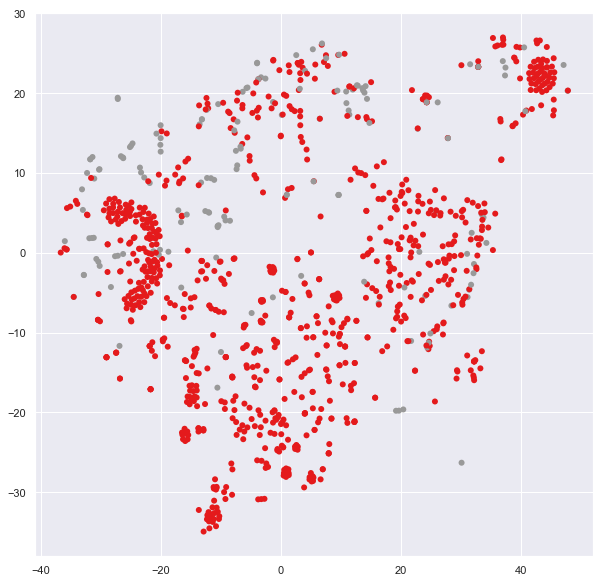

In [40]:
tsne = TSNE(n_components = 2, perplexity = 40)
Z = tsne.fit_transform(X)
plt.figure(figsize = (10, 10))
plt.scatter(Z[:, 0], Z[:, 1], c=y, linewidths=0, cmap='Set1')
plt.show()

Как видно, ничего кластеризовать не получается (Иммется в виду серые точки, которые отвечают за неактивных клиентов).

In [41]:
import matplotlib.patches as mpatches

In [42]:
from sklearn.cluster import KMeans

In [43]:
# Визуалтизация кластеров
def show_cluster(num, df, X_real, num_of_weeks_to_show = 4, max_y = None):
    curr_df = df[df["clusters"] == num]
    puids = curr_df["puid"].unique()
    plt.figure(figsize=(20, 7))
    y = np.array(df["clusters"] == num)
    X = X_real[y]
    print("Количество id-ков:", X.shape[0])
    print("Количество неактивных пользователей:", curr_df[curr_df["out_of_cloud"] == 1].shape[0])
    print("Количество активных пользователей:", curr_df[curr_df["out_of_cloud"] == 0].shape[0])
    
    ind = 1
    plt.subplot(1, 2, ind)
    ind += 1
    title = "Кластер номер " + str(num)
    title += " (за посдедние {} недели)".format(num_of_weeks_to_show)

    plt.title(title, fontsize = 12)
    colors = ["orangered", "black"]
    red_patch = mpatches.Patch(color='orangered', label='активны')
    black_patch = mpatches.Patch(color='black', label='не активны')

    for puid in puids:
        df["out_of_cloud"] = df["out_of_cloud"].astype(int)
        consu = np.array(df[df["puid"] == puid].drop(columns = ["puid", "out_of_cloud", "clusters"]))[0]
        plt.plot(np.arange(1, num_of_weeks_to_show + 1), consu, \
                 color = colors[df[df["puid"] == puid]["out_of_cloud"].iloc[0]])
    plt.xlabel("День", fontsize = 12)
    plt.ylabel("Consumption", fontsize = 12)
    plt.legend(handles=[red_patch, black_patch], fontsize = 15)
    if max_y == max_y:
        plt.ylim((-1, max_y))
    
    ind = 3
    plt.subplot(1, 3, ind)
    ind += 1
    plt.title("boxplot за последние {} недель (Для нормализованных данныз)".format(\
                                                    num_of_weeks_to_show), fontsize = 15)
    
    #print(X)
    #print(np.flip(X))
    box = plt.boxplot(X)
    plt.show()

In [44]:
def create_cluster_table(curr_df, num_clusters):
    df = curr_df.copy()
    X, y = prepare_cluster_X_y(df) 
    model = KMeans(n_clusters=num_clusters).fit(X)
    clusters = model.predict(X)
    df["clusters"] = clusters
    print(X.shape)
    for i in np.unique(clusters):
        show_cluster(i, df, X, num_of_weeks_to_show = 28)
    gc.collect()
    return model, df

(160, 28)
Количество id-ков: 15
Количество неактивных пользователей: 15
Количество активных пользователей: 0


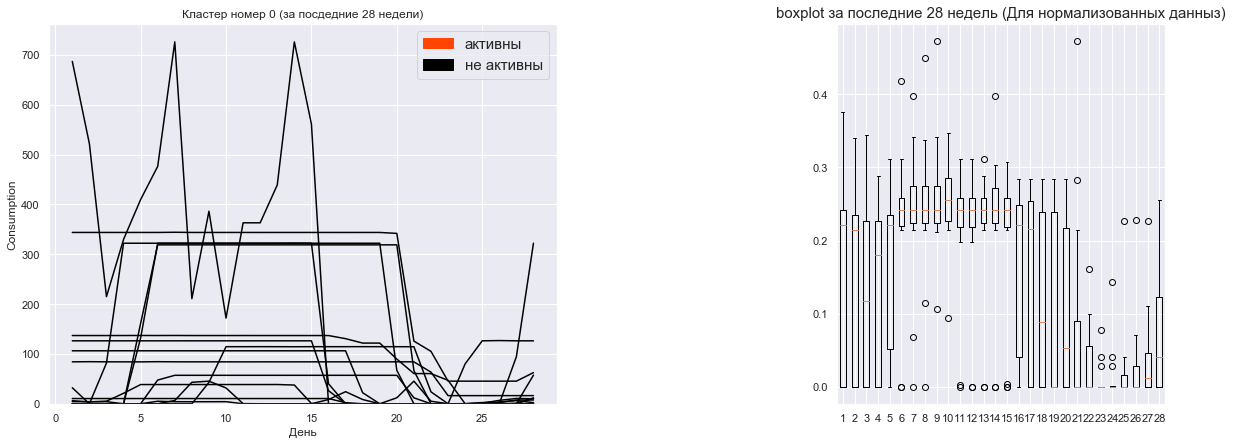

Количество id-ков: 105
Количество неактивных пользователей: 105
Количество активных пользователей: 0


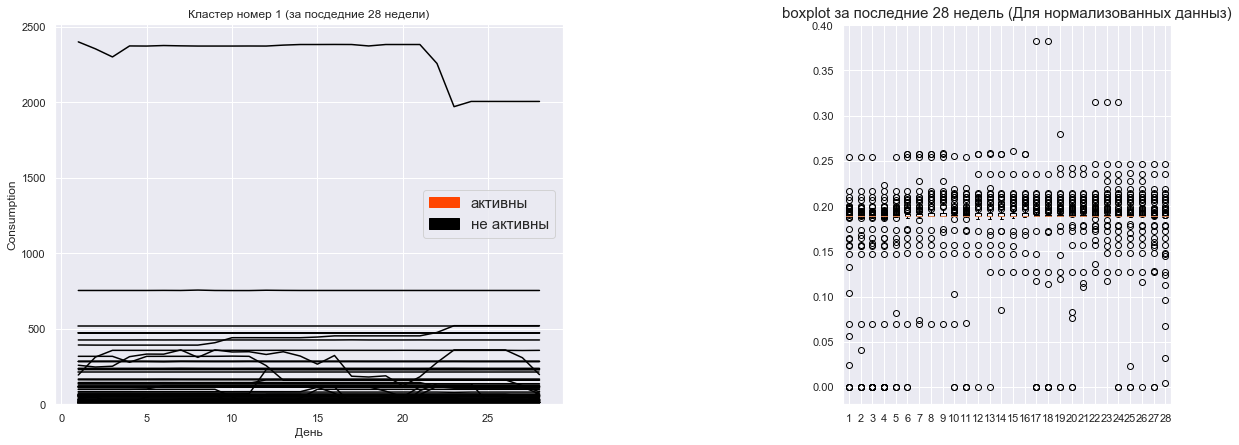

Количество id-ков: 10
Количество неактивных пользователей: 10
Количество активных пользователей: 0


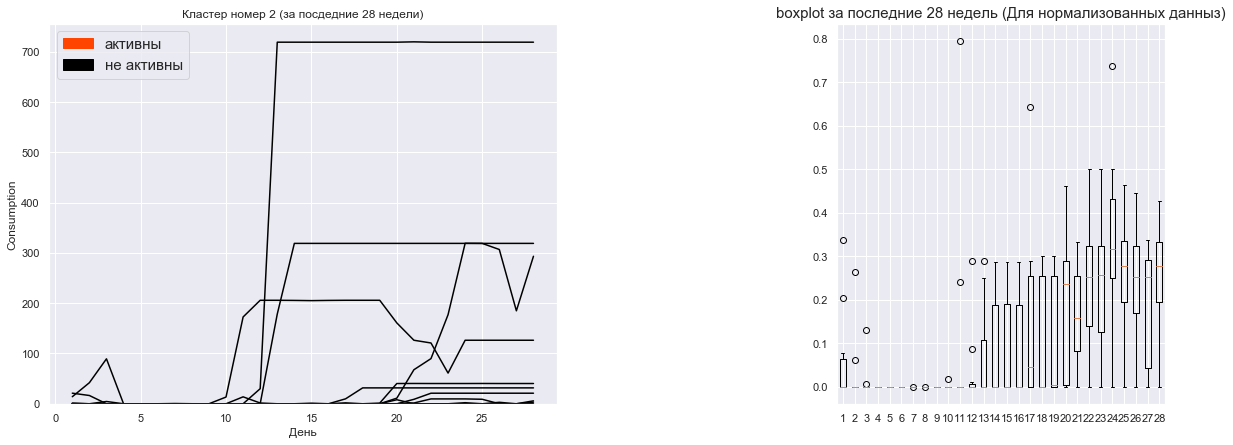

Количество id-ков: 11
Количество неактивных пользователей: 11
Количество активных пользователей: 0


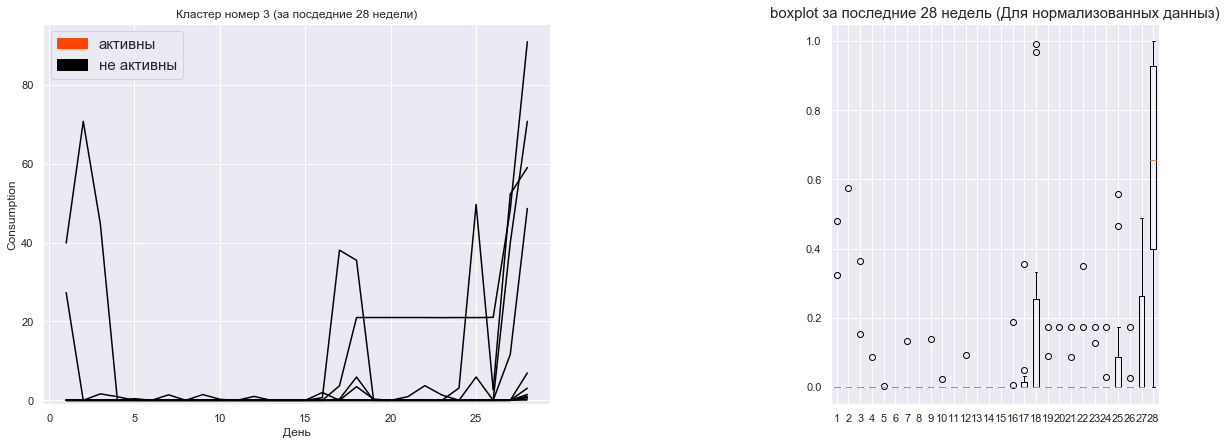

Количество id-ков: 19
Количество неактивных пользователей: 19
Количество активных пользователей: 0


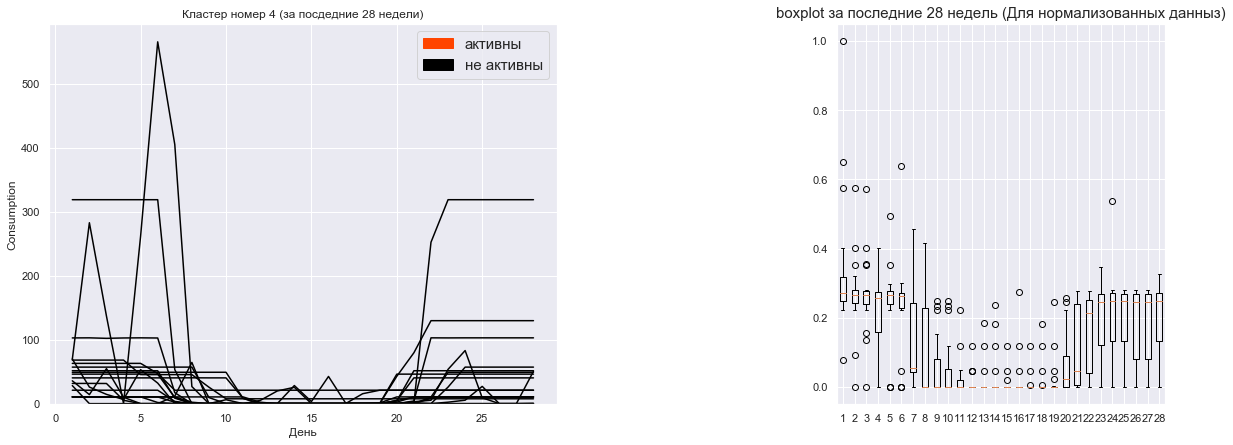

In [45]:
daymodel, _ = create_cluster_table(compute_cluster_day_df[compute_cluster_day_df["out_of_cloud"] == 1], 5)

Количество id-ков: 29
Количество неактивных пользователей: 15
Количество активных пользователей: 14


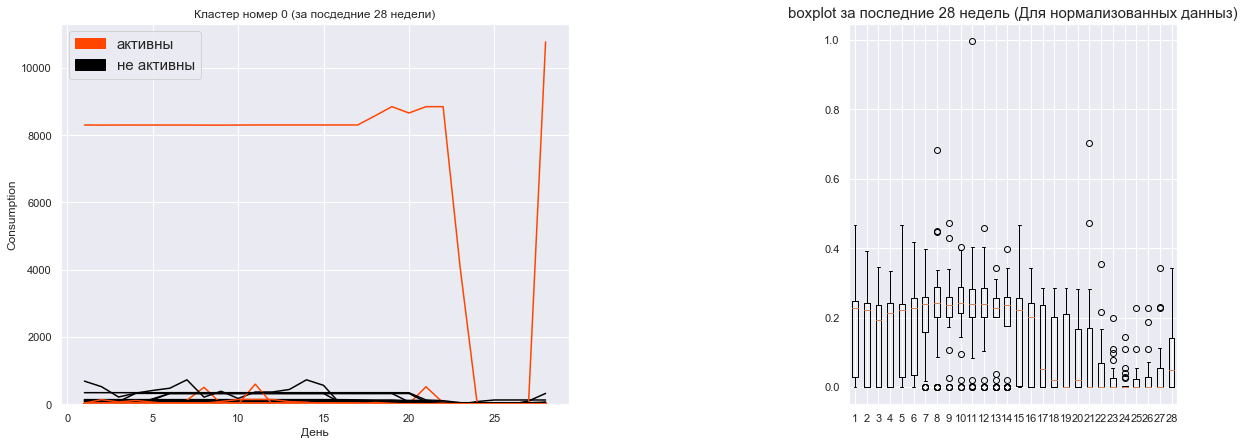

Количество id-ков: 860
Количество неактивных пользователей: 105
Количество активных пользователей: 755


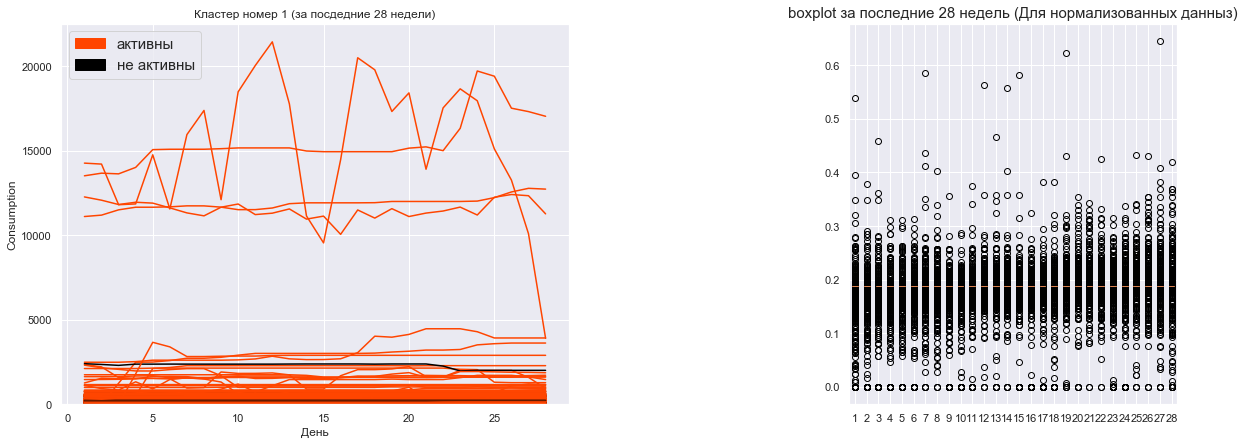

Количество id-ков: 97
Количество неактивных пользователей: 10
Количество активных пользователей: 87


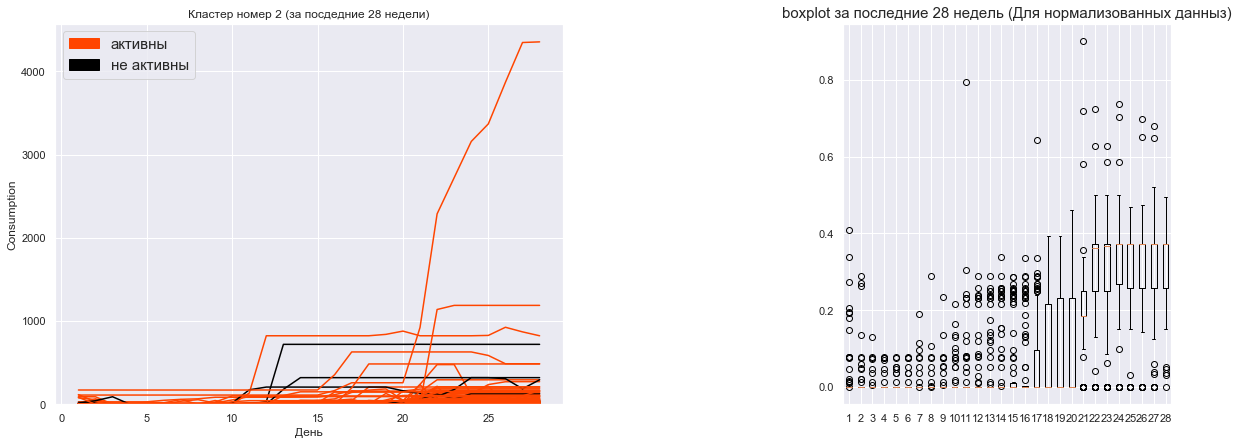

Количество id-ков: 32
Количество неактивных пользователей: 11
Количество активных пользователей: 21


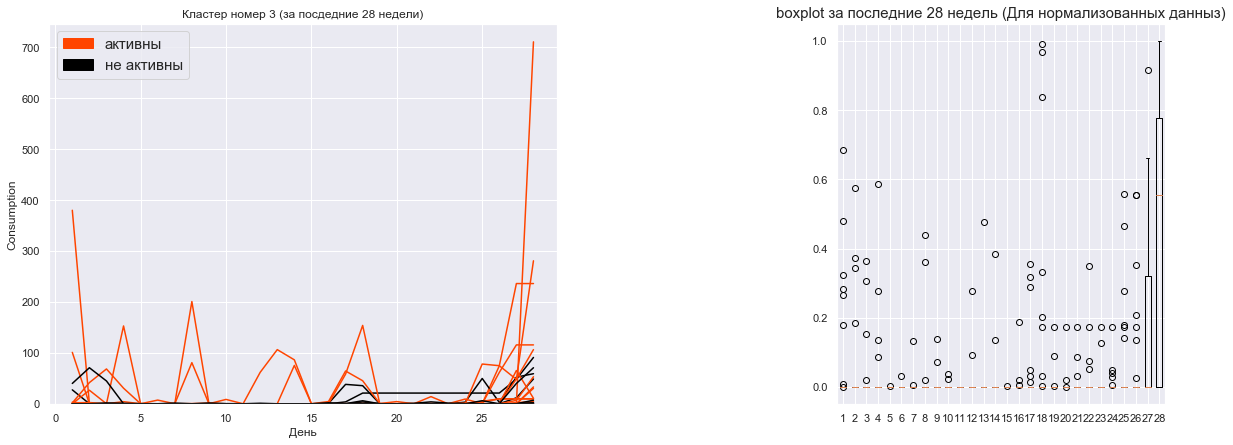

Количество id-ков: 48
Количество неактивных пользователей: 19
Количество активных пользователей: 29


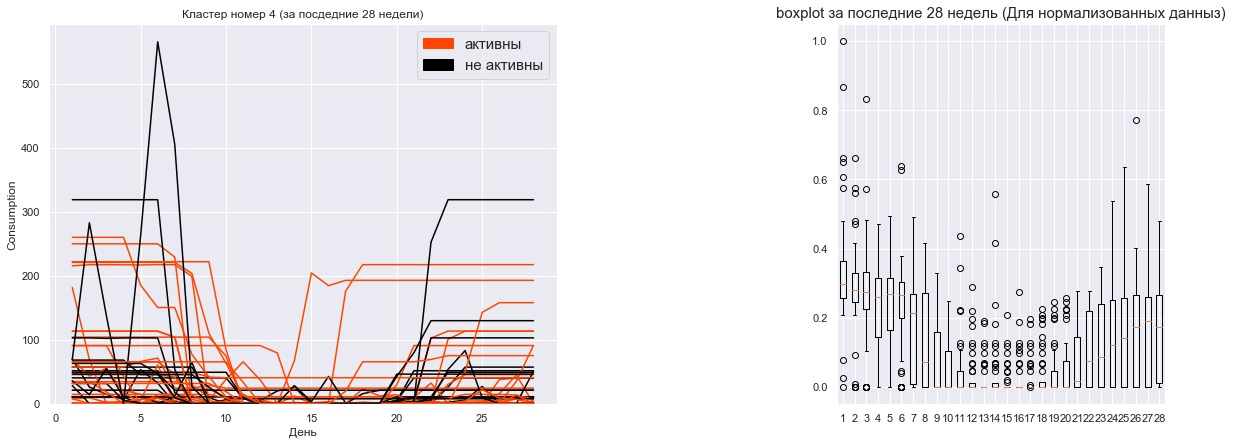

In [46]:
clusters = daymodel.predict(X)
compute_cluster_day_df["clusters"] = clusters
for i in np.unique(clusters):
    show_cluster(i, compute_cluster_day_df, X, num_of_weeks_to_show = 28)

## По неделям

Делаем то же самое, что и с днями.

In [47]:
compute_clustering_df = compute_person_df[["real_consumption_-4",
                                          "real_consumption_-3",
                                          "real_consumption_-2",
                                          "real_consumption_-1",
                                          "puid",
                                          "out_of_cloud"]]

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [49]:
def prepare_cluster_X_y(df):
    y = df["out_of_cloud"]
    cols = ["out_of_cloud", "puid"]
    if "clusters" in df.columns:
        cols.append("clusters")
    X = df.drop(columns = cols)
    #scaler = StandardScaler()
    normalizer = Normalizer()
    #X = scaler.fit_transform(X)
    X = normalizer.fit_transform(X)
    return X, y

In [50]:
X, y = prepare_cluster_X_y(compute_clustering_df)

In [51]:
X.shape

(1066, 4)

### TSNE (by weeks)

In [52]:
from sklearn.manifold import TSNE

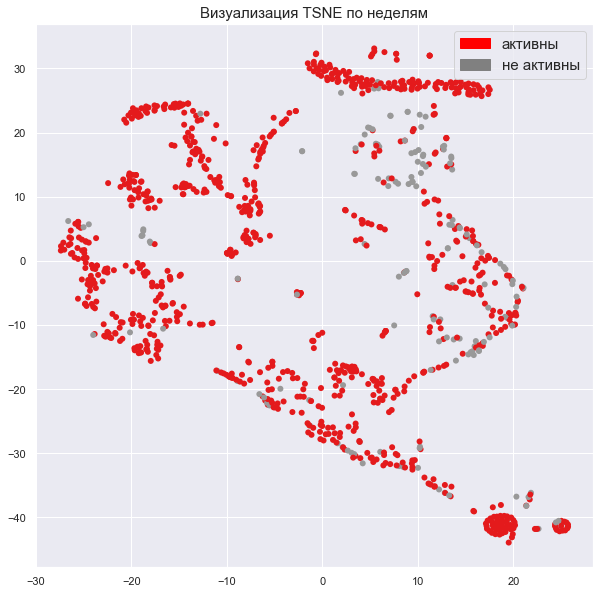

In [53]:
tsne = TSNE(n_components = 2, perplexity = 40)
Z = tsne.fit_transform(X)
plt.figure(figsize = (10, 10))
plt.title("Визуализация TSNE по неделям", fontsize = 15)
red_patch = mpatches.Patch(color='red', label='активны')
grey_patch = mpatches.Patch(color='grey', label='не активны')
plt.scatter(Z[:, 0], Z[:, 1], c=y, linewidths=0, cmap='Set1')
plt.legend(handles=[red_patch, grey_patch], fontsize = 15)
plt.show()

Есть возможная кластеризация, но не сильно удачная... Выделим ее с помощью DBSCAN

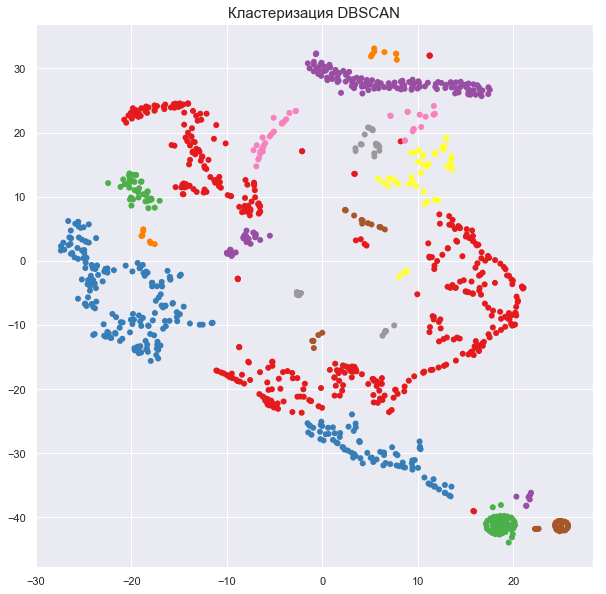

In [54]:
from sklearn.cluster import DBSCAN
dbmodel = DBSCAN(eps = 2, min_samples = 5)
tsne_clusts = dbmodel.fit_predict(Z)
plt.figure(figsize = (10, 10))
plt.title("Кластеризация DBSCAN", fontsize = 15)
plt.scatter(Z[:, 0], Z[:, 1], c=tsne_clusts, linewidths=0, cmap='Set1')
plt.show()

In [55]:
# Визуалтизация кластеров
def show_cluster(num, df, X_real, num_of_weeks_to_show = 4, max_y = None):
    curr_df = df[df["clusters"] == num]
    puids = curr_df["puid"].unique()
    plt.figure(figsize=(20, 7))
    y = np.array(df["clusters"] == num)
    X = X_real[y]
    print("Количество id-ков:", X.shape[0])
    print("Количество неактивных пользователей:", curr_df[curr_df["out_of_cloud"] == 1].shape[0])
    print("Количество активных пользователей:", curr_df[curr_df["out_of_cloud"] == 0].shape[0])
    
    ind = 1
    plt.subplot(1, 2, ind)
    ind += 1
    title = "Кластер номер " + str(num)
    title += " (за посдедние {} недели)".format(num_of_weeks_to_show)

    plt.title(title, fontsize = 12)
    colors = ["orangered", "black"]
    red_patch = mpatches.Patch(color='orangered', label='активны')
    black_patch = mpatches.Patch(color='black', label='не активны')

    for puid in puids:
        df["out_of_cloud"] = df["out_of_cloud"].astype(int)
        consu = np.array(df[df["puid"] == puid].drop(columns = ["puid", "out_of_cloud", "clusters"]))[0]
        plt.plot(np.arange(1, num_of_weeks_to_show + 1), consu, \
                 color = colors[df[df["puid"] == puid]["out_of_cloud"].iloc[0]])
    plt.xlabel("Неделя", fontsize = 12)
    plt.ylabel("Consumption", fontsize = 12)
    plt.legend(handles=[red_patch, black_patch], fontsize = 15)
    if max_y == max_y:
        plt.ylim((-1, max_y))
    
    ind = 2
    plt.subplot(1, 2, ind)
    ind += 1
    plt.title("boxplot за последние {} недель (Для нормализованных данныз)".format(\
                                                    num_of_weeks_to_show), fontsize = 15)
    
    #print(X)
    #print(np.flip(X))
    box = plt.boxplot(X)
    plt.show()

Посчитаем кластеры, в которых много неактивных пользователей (bad), и те, в которых много активных (good или verygood) и визувализируем плохие и очень хорошие кластера.

Количество id-ков: 125
Количество неактивных пользователей: 1
Количество активных пользователей: 124


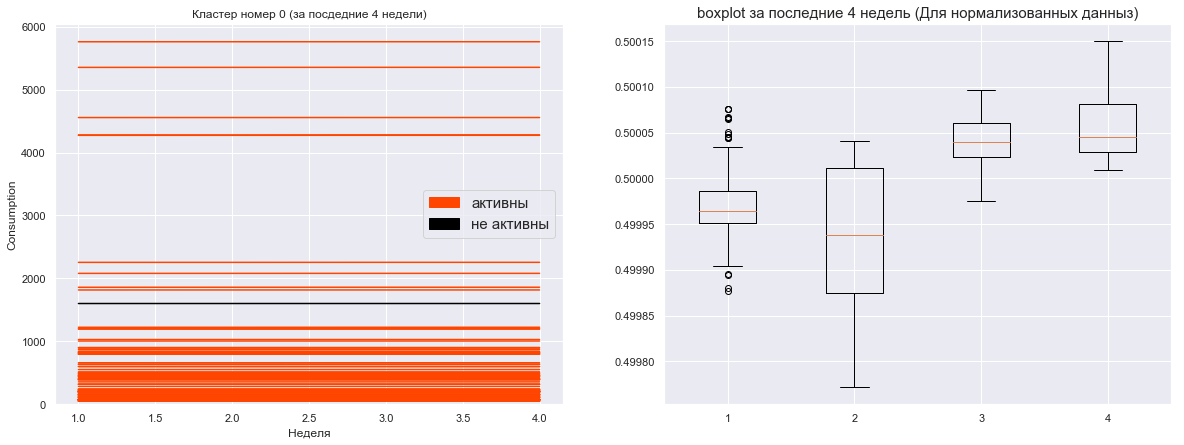

Количество id-ков: 171
Количество неактивных пользователей: 6
Количество активных пользователей: 165


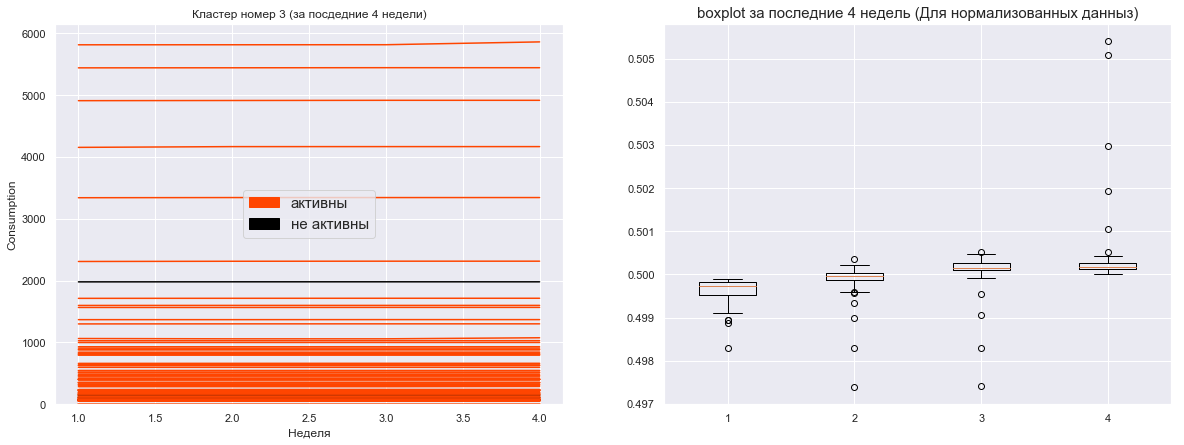

Количество id-ков: 44
Количество неактивных пользователей: 0
Количество активных пользователей: 44


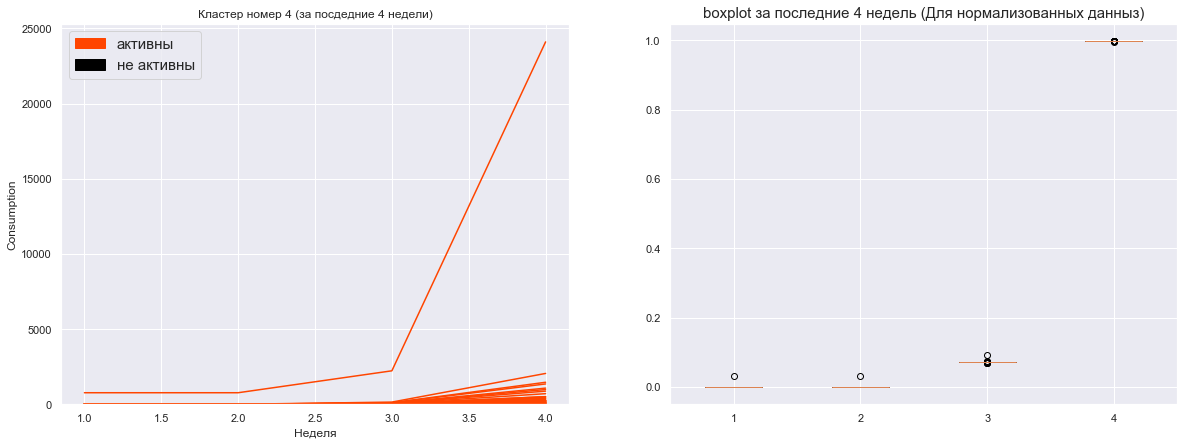

Количество id-ков: 37
Количество неактивных пользователей: 0
Количество активных пользователей: 37


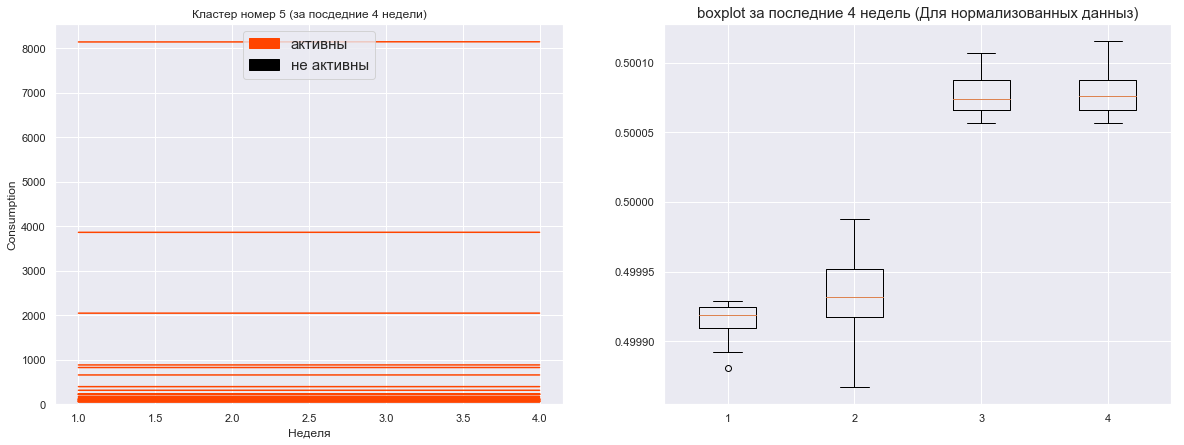

Количество id-ков: 24
Количество неактивных пользователей: 0
Количество активных пользователей: 24


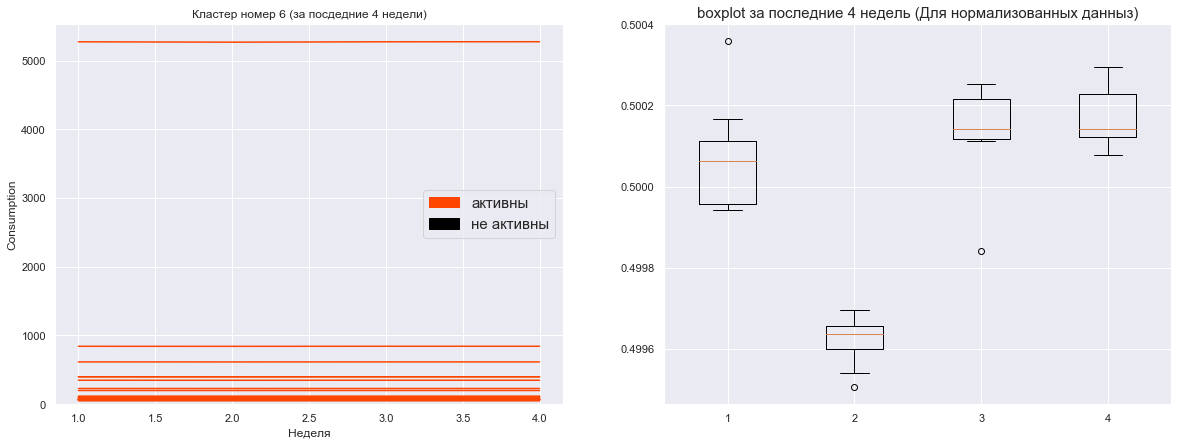

Количество id-ков: 117
Количество неактивных пользователей: 4
Количество активных пользователей: 113


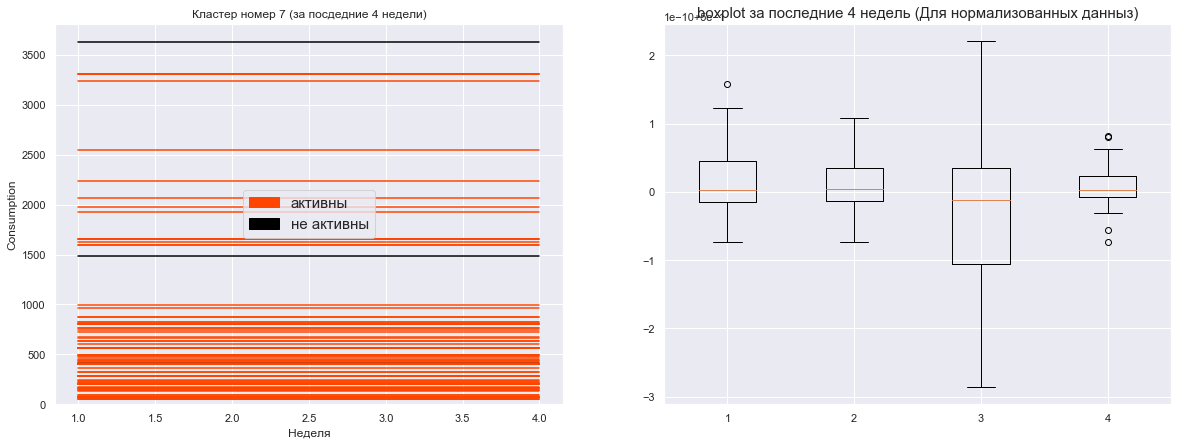

Количество id-ков: 8
Количество неактивных пользователей: 0
Количество активных пользователей: 8


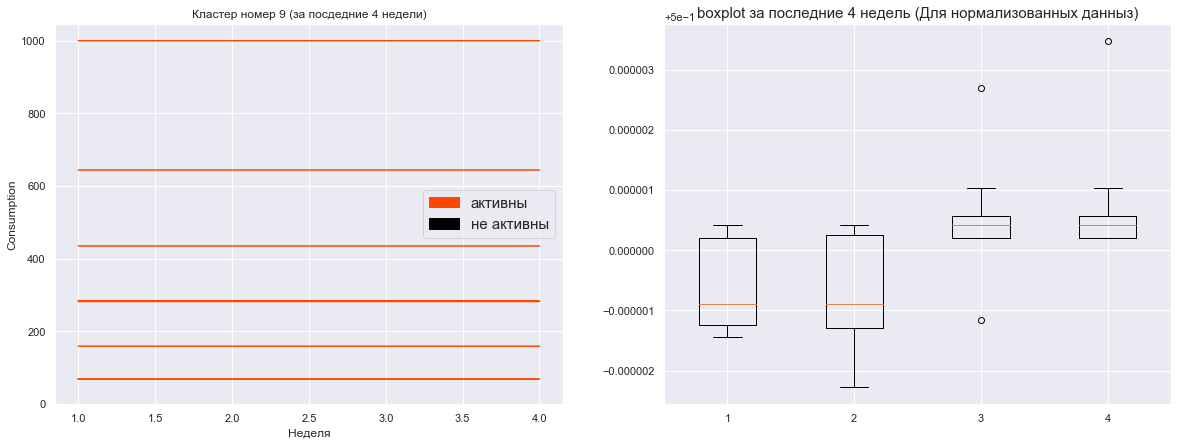

cluster number: 10 bad, proc: 87.5
Количество id-ков: 8
Количество неактивных пользователей: 7
Количество активных пользователей: 1


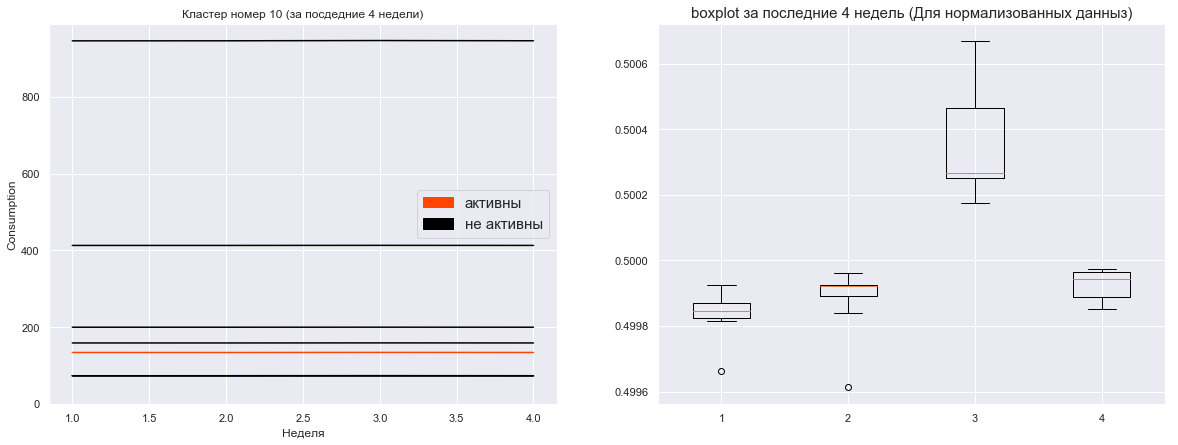

cluster number: 11 bad, proc: 62.7906976744186
Количество id-ков: 43
Количество неактивных пользователей: 27
Количество активных пользователей: 16


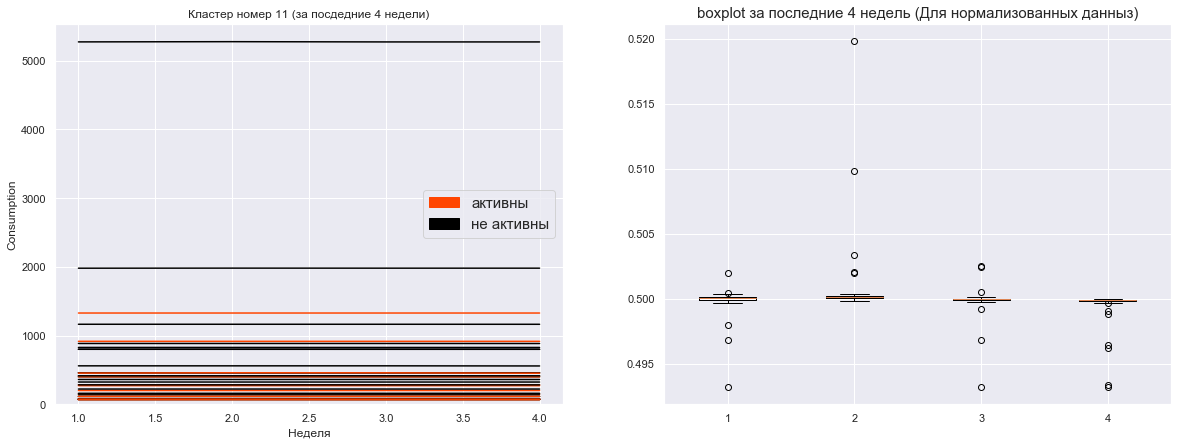

cluster number: 12 bad, proc: 83.33333333333334
Количество id-ков: 6
Количество неактивных пользователей: 5
Количество активных пользователей: 1


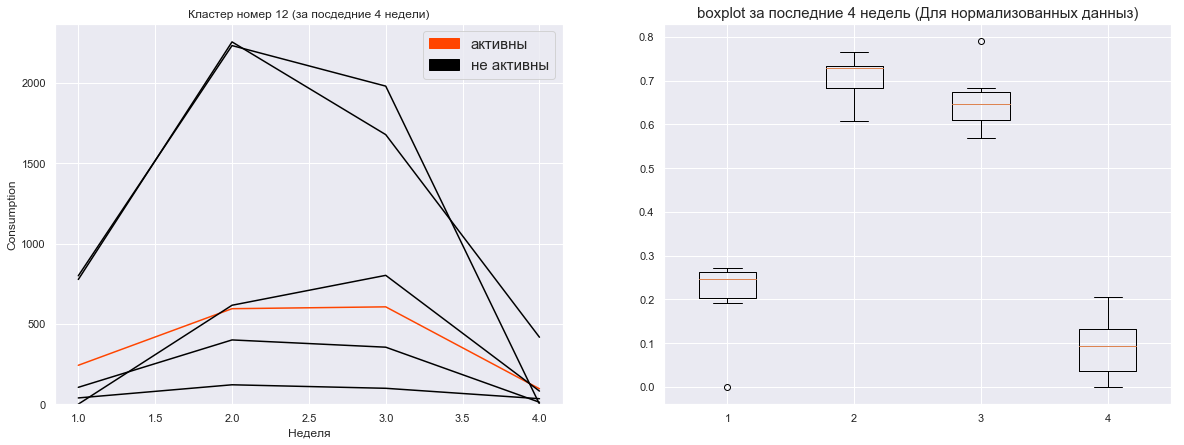

Количество id-ков: 6
Количество неактивных пользователей: 0
Количество активных пользователей: 6


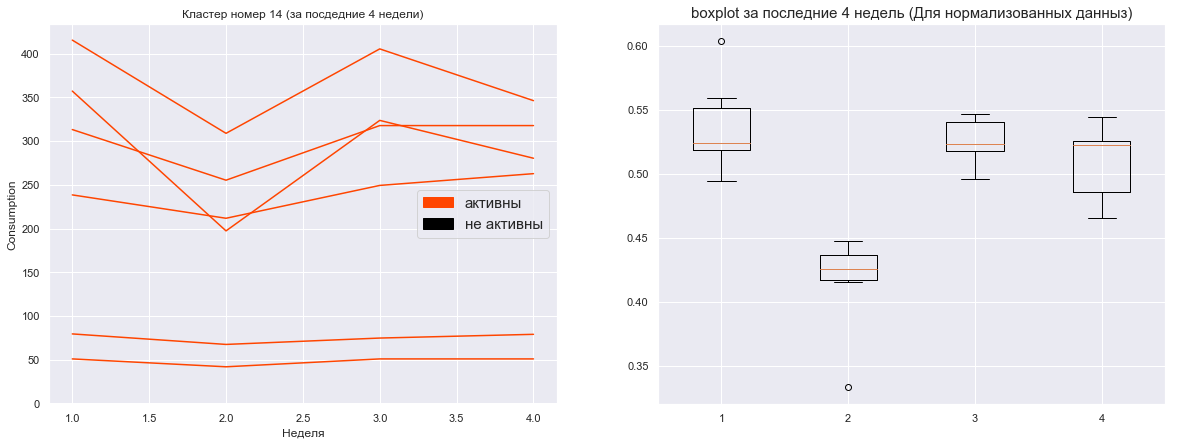

Количество id-ков: 14
Количество неактивных пользователей: 0
Количество активных пользователей: 14


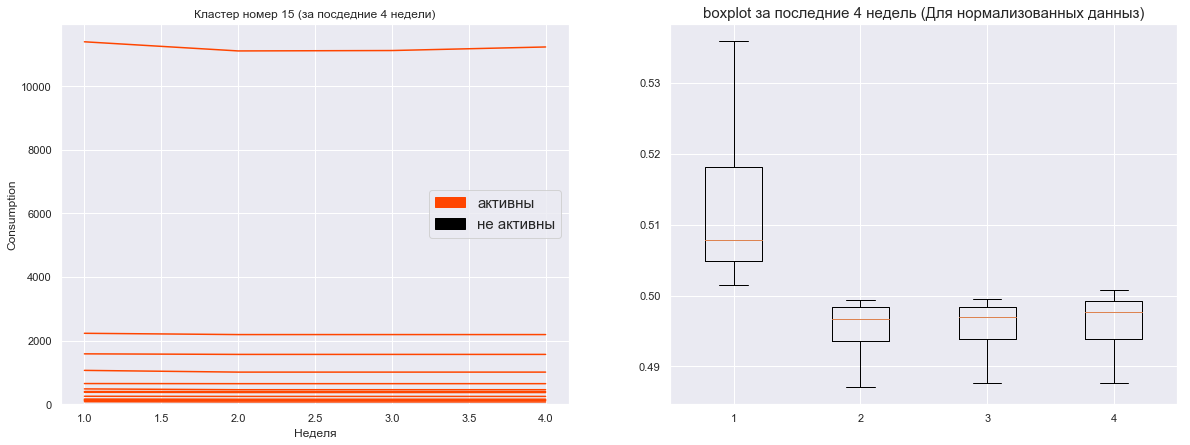

Количество id-ков: 26
Количество неактивных пользователей: 0
Количество активных пользователей: 26


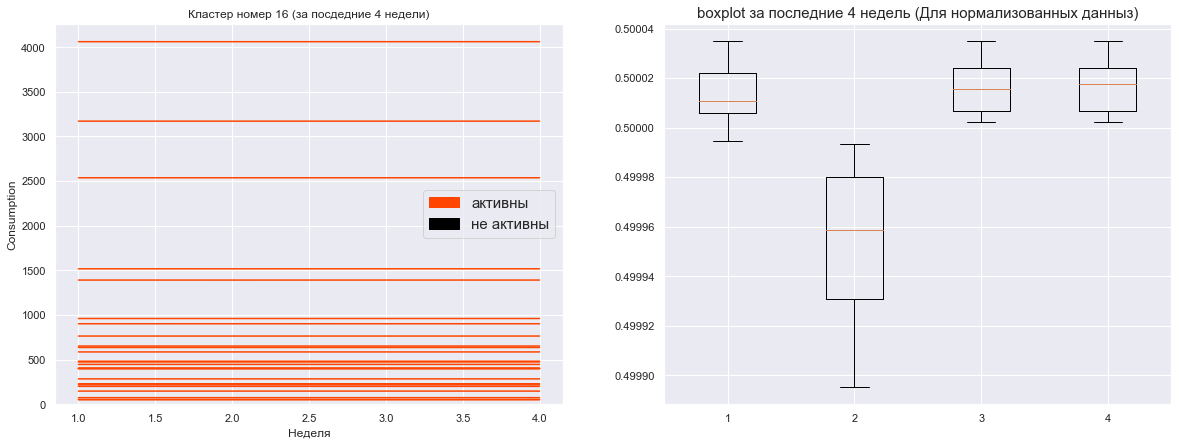

In [56]:
goods = []
bads = []
very_goods = []
df_copy = compute_clustering_df.copy()
df_copy["clusters"] = tsne_clusts
for cluster in np.unique(tsne_clusts):
    curr = df_copy[df_copy["clusters"] == cluster]
    if curr[curr["out_of_cloud"] == 1].shape[0] / curr.shape[0] * 100 > 60:
        print("cluster number:", cluster, "bad, proc:", curr[curr["out_of_cloud"] == 1].shape[0] / \
              curr.shape[0] * 100)
        show_cluster(cluster, df_copy, X, num_of_weeks_to_show = 4)
        bads.append(cluster)
    else:
        goods.append(cluster)
        if curr[curr["out_of_cloud"] == 0].shape[0] / curr.shape[0] * 100 > 90:
            show_cluster(cluster, df_copy, X, num_of_weeks_to_show = 4)
            very_goods.append(cluster)

Визуализируем отмеченные плохие точки.

In [57]:
colors = np.ones(tsne_clusts.shape[0])
colors[np.in1d(tsne_clusts, bads)] = 2
colors[np.in1d(tsne_clusts, very_goods)] = 0

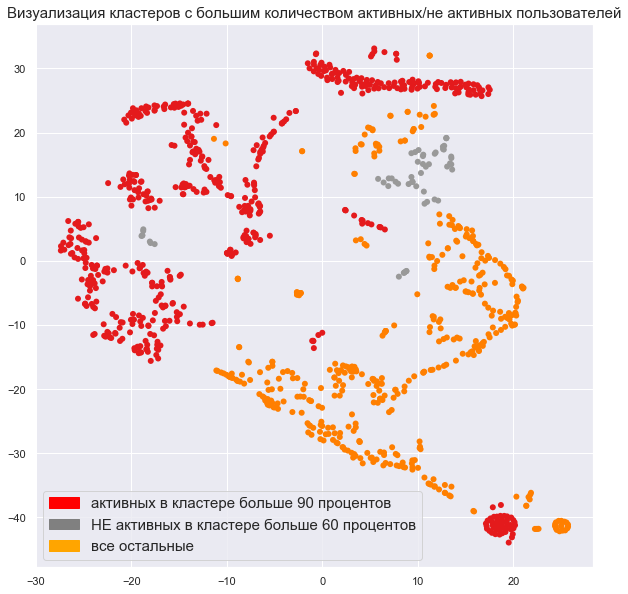

In [58]:
plt.figure(figsize = (10, 10))
plt.title("Визуализация кластеров с большим количеством активных/не активных пользователей", fontsize = 15)
plt.scatter(Z[:, 0], Z[:, 1], c=colors, linewidths=0, cmap='Set1')
red_patch = mpatches.Patch(color='red', label='активных в кластере больше 90 процентов')
grey_patch = mpatches.Patch(color='grey', label='НЕ активных в кластере больше 60 процентов')
orange_patch = mpatches.Patch(color='orange', label='все остальные')
plt.legend(handles=[red_patch, grey_patch, orange_patch], fontsize = 15)
plt.show()

In [59]:
compute_curr_df = compute_person_df.copy()
compute_curr_df["clusters"] = tsne_clusts
bad_df = compute_curr_df[compute_curr_df["clusters"].isin(bads)]
good_df = compute_curr_df[compute_curr_df["clusters"].isin(goods)]

In [60]:
bad_df[bad_df["out_of_cloud"] == 1].shape[0] / df_copy[df_copy["out_of_cloud"] == 1].shape[0]

0.24375

In [61]:
bad_df[bad_df["out_of_cloud"] == 1].shape[0]

39

In [62]:
df_copy[df_copy["out_of_cloud"] == 1].shape[0]

160

Всего 24 процента от всех неактивов находится в этих кластерах.

Посмторим как фичи compute сервиса влияют на плохие (где больше 60 процентов - неактивные клиенты) и очень хорошие кластера (где больше 90 процентов - активные клиенты). (Воспользуюсь критерием Вальда для бернуллевских выборок, потом МПГ методом Холма(множественная проверка гипотез), те фичи, где влияние на кластер стат. значимо - отмечены черным).

In [63]:
from statsmodels.stats import multitest
def wald(n, m, p1, p2):
    sigma = np.sqrt(p1*(1 - p1) / n + p2 * (1 - p2) / m)
    return (p1 - p2) / sigma

def wald_test(X, Y):
    ans = sps.norm.cdf(wald(X.shape[0], Y.shape[0], np.mean(X), np.mean(y)))
    return ans

def two_sided_wald_test(X, Y):
    if wald_test(X, Y) < 0.05:
        return (True, wald_test(X, Y))
    if wald_test(Y, X) < 0.05:
        return (True, wald_test(Y, X))
    return False, min(wald_test(Y, X), wald_test(X, Y))

In [64]:
def clusters_diff(bads, goods, clusts, min_days):
    alls = np.concatenate([bads, goods])
    compute_curr_df["clusters"] = clusts
    curr = compute_curr_df.copy()
    cols = ["non_zero_days_" + col for col in compute_cols]
    num = 0
    pval = []
    curr = curr[curr["clusters"].isin(alls)]
    curr["bads"] = curr["clusters"].isin(bads)
    for col, name in zip(cols,  compute_cols):
        temp_1 = curr[curr[col] >  min_days]
        temp_2 = curr[curr[col] <=  min_days]
        #print(temp_1.shape[0], temp_2.shape[0])
        if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
            continue
        num += 1
        
        X = np.array(temp_1["bads"])
        Y = np.array(temp_2["bads"])
        #print(X.mean(), Y.mean(), X.shape, Y.shape)
        #print("=======")
        prin, res = two_sided_wald_test(X, Y)
        pval.append(res)
    
  #  print(pval)
    h1, holm, _, _= multitest.multipletests(pval, method = 'holm')
    #print("FWER: answers:", h1, "Holms corrected p_val:", holm)
    plt.figure(figsize = (15, 20))
    ind = 1
    for col, name in zip(cols,  compute_cols):
        temp_1 = curr[curr[col] >  min_days]
        temp_2 = curr[curr[col] <=  min_days]
        if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
            continue
        X = np.array(temp_1["bads"])
        Y = np.array(temp_2["bads"])
        prin, res = two_sided_wald_test(X, Y)
        if h1[ind - 1]:
            print(name, "corrected p-val:", holm[ind - 1])
            print("num of use:", temp_1.shape[0])
            print("num of no use: ", temp_2.shape[0])
            print("================================")
            #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "black")
            plt.ylabel("Процент в плохих кластерах", fontsize = 15)
            ind += 1
        else:
            print(name, "corrected p-val:", holm[ind - 1])
            print("num of use:", temp_1.shape[0])
            print("num of no use: ", temp_2.shape[0])
            print("================================")
            #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "orangered")
            plt.ylabel("Процент в плохих кластерах", fontsize = 15)
            ind += 1
        #print("================================================================================================\n")
    plt.show()

core_5.0 corrected p-val: 0.06847470311512412
num of use: 339
num of no use:  290
core_100.0 corrected p-val: 0.0322298512815726
num of use: 254
num of no use:  375
platform_v1 corrected p-val: 0.002085983394947574
num of use: 459
num of no use:  170
platform_v2 corrected p-val: 9.524712619374179e-06
num of use: 145
num of no use:  484
subservice_cpu corrected p-val: 0.25198823364597356
num of use: 581
num of no use:  48
subservice_ram corrected p-val: 0.25198823364597356
num of use: 581
num of no use:  48
subservice_windows corrected p-val: 0.19451831293453087
num of use: 83
num of no use:  546


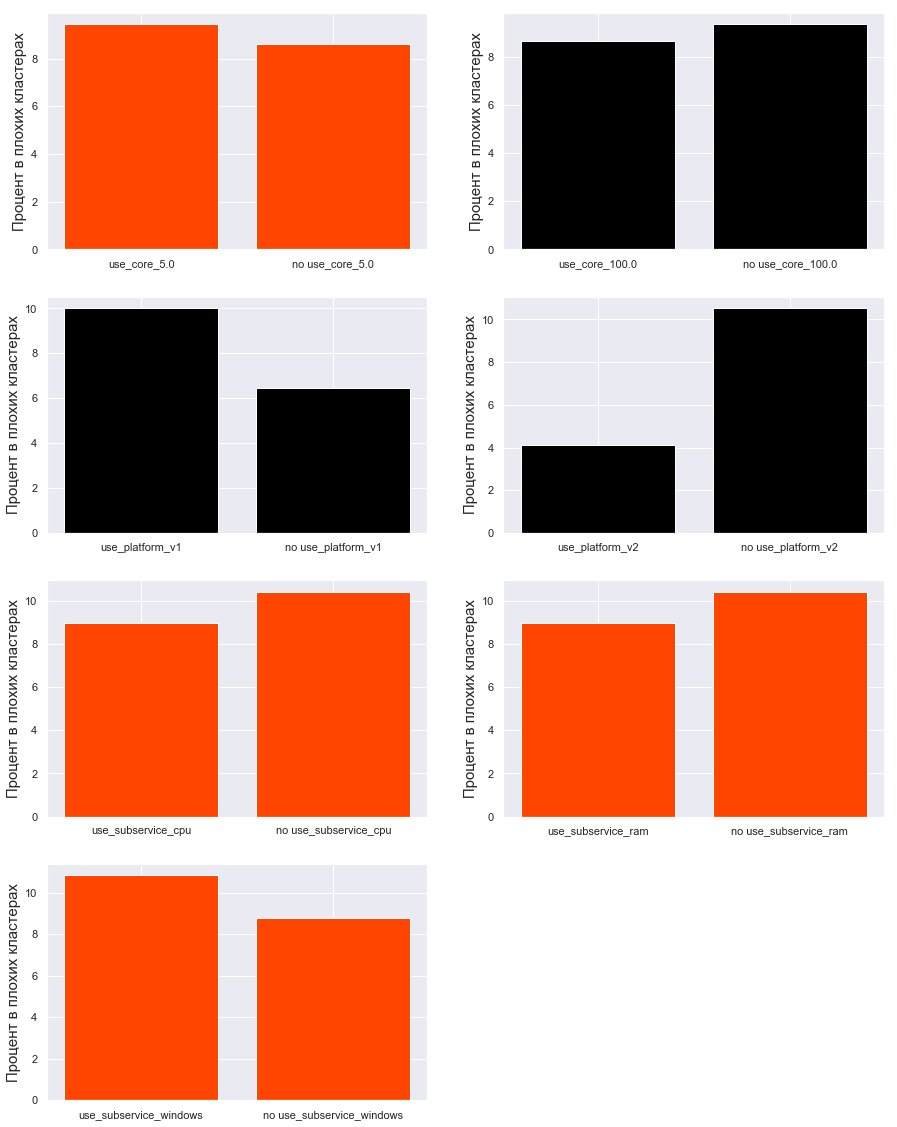

In [65]:
clusters_diff(bads, very_goods, tsne_clusts, 20)

Как видно, реальная разница есть для платформы (Для плохих кластеров характерно использование 1 платформы, для хороших - наоборот), а также для использования ядра на 100 процентов (хотя pvalue уже 0.03, стоит быть осторожным).

-------

## KMeans 

Кластеризуем с помощью KMeans

In [66]:
import matplotlib.patches as mpatches

In [67]:
from sklearn.cluster import KMeans

In [68]:
def create_cluster_table(curr_df, num_clusters):
    df = curr_df.copy()
    X, y = prepare_cluster_X_y(df) 
    model = KMeans(n_clusters=num_clusters).fit(X)
    clusters = model.predict(X)
    df["clusters"] = clusters
    print(X.shape)
    for i in np.unique(clusters):
        show_cluster(i, df, X, num_of_weeks_to_show = 4)
    gc.collect()
    return model, df

(160, 4)
Количество id-ков: 100
Количество неактивных пользователей: 100
Количество активных пользователей: 0


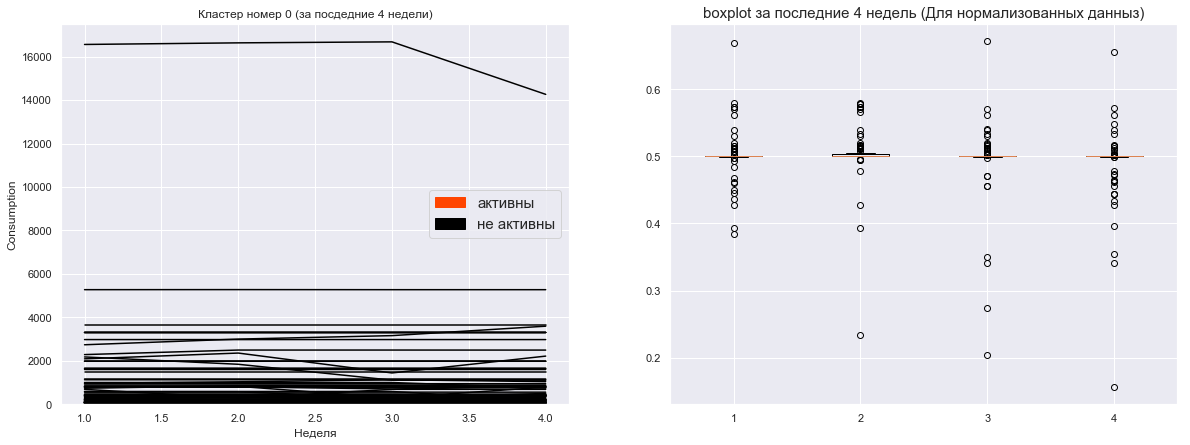

Количество id-ков: 15
Количество неактивных пользователей: 15
Количество активных пользователей: 0


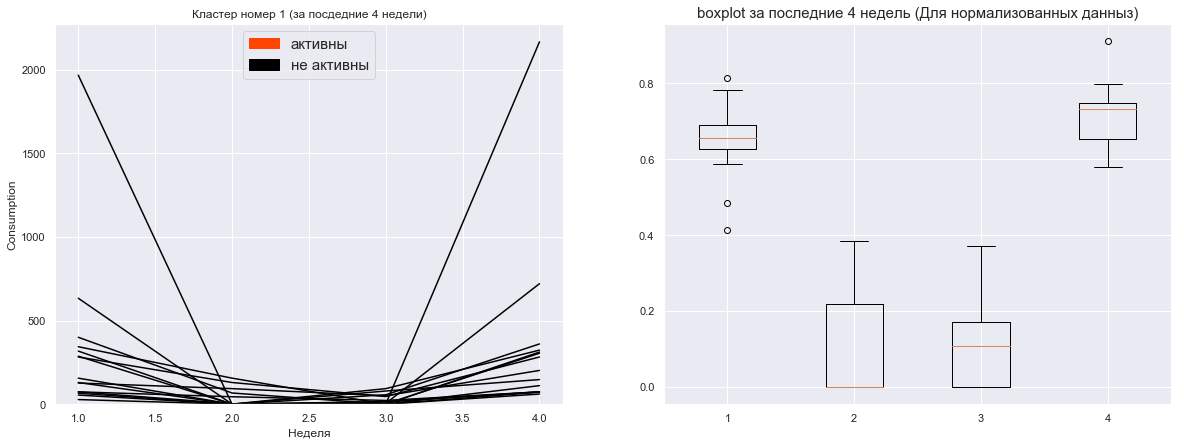

Количество id-ков: 10
Количество неактивных пользователей: 10
Количество активных пользователей: 0


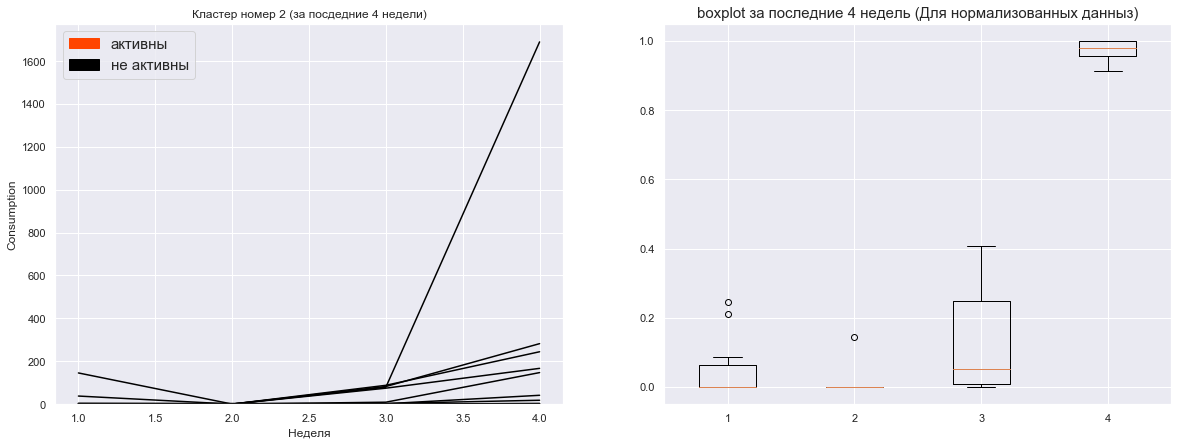

Количество id-ков: 8
Количество неактивных пользователей: 8
Количество активных пользователей: 0


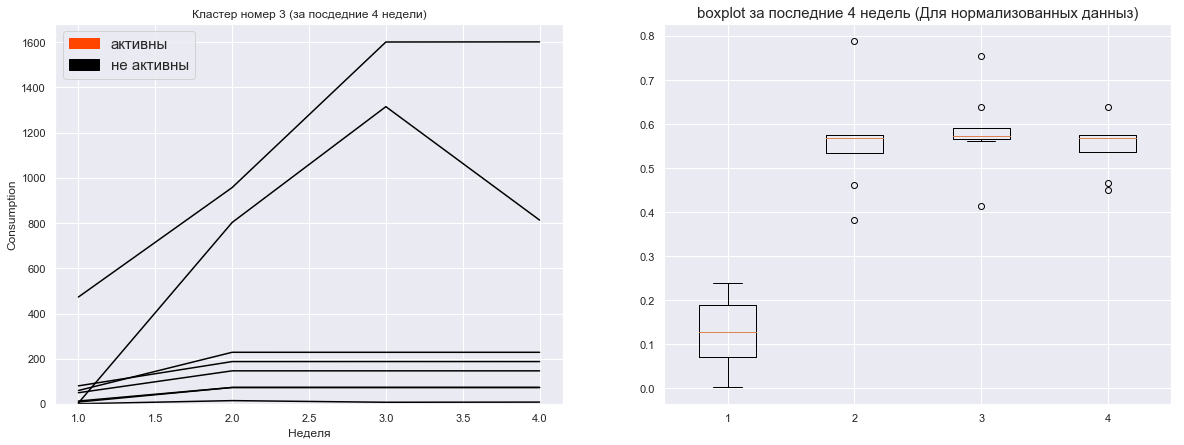

Количество id-ков: 6
Количество неактивных пользователей: 6
Количество активных пользователей: 0


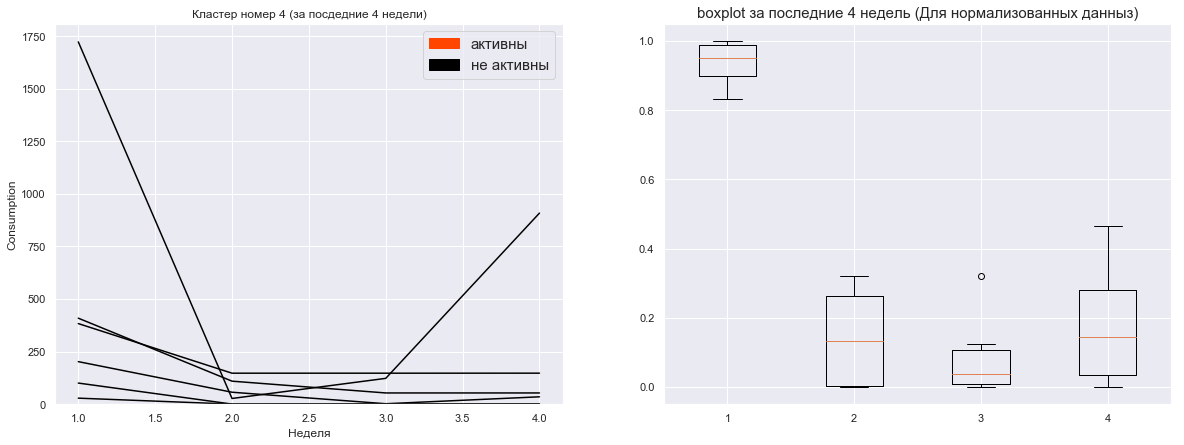

Количество id-ков: 9
Количество неактивных пользователей: 9
Количество активных пользователей: 0


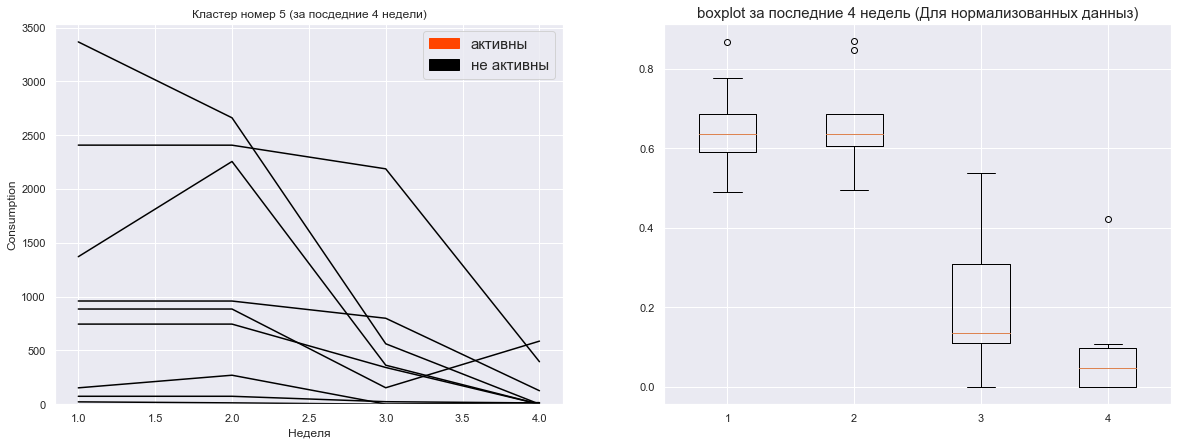

Количество id-ков: 7
Количество неактивных пользователей: 7
Количество активных пользователей: 0


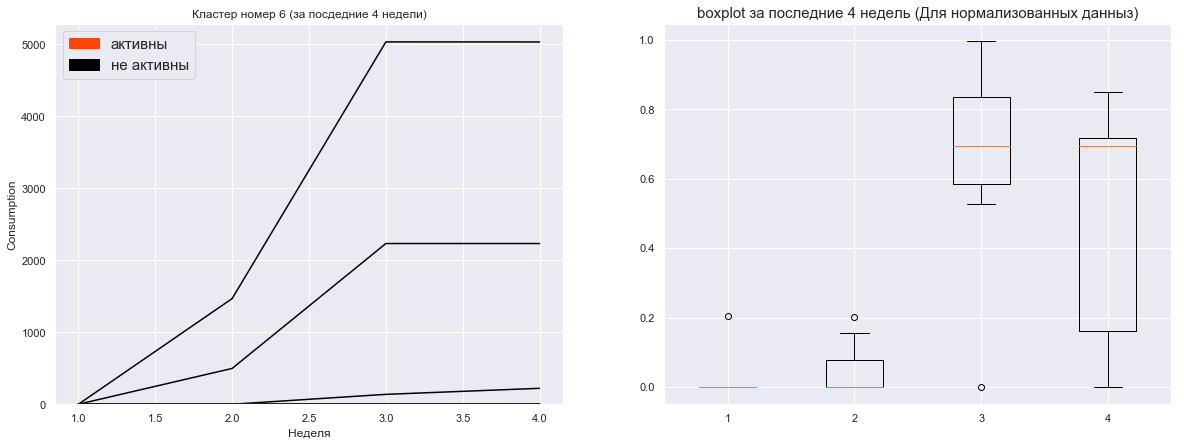

Количество id-ков: 5
Количество неактивных пользователей: 5
Количество активных пользователей: 0


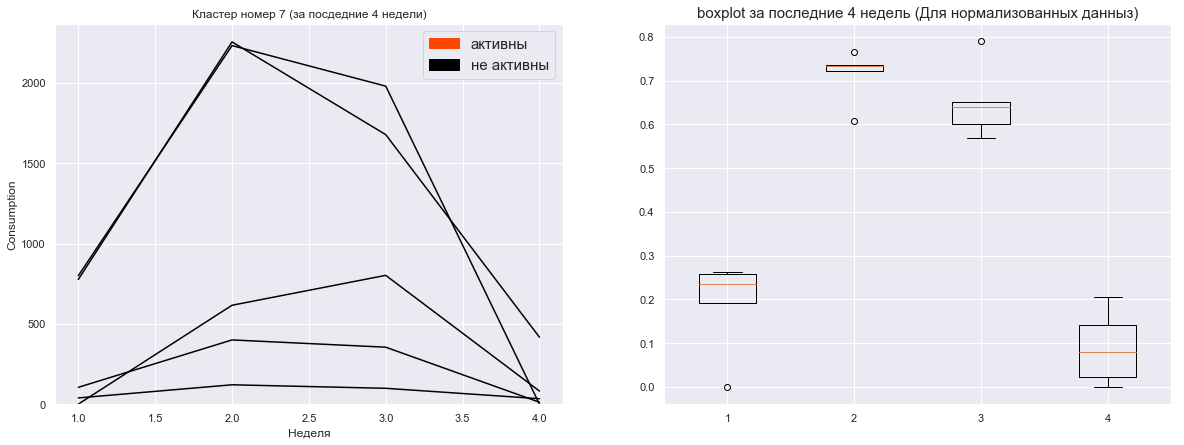

In [69]:
num_of_clusters = 8
cluster_model, out_of_clustering_df = \
create_cluster_table(compute_clustering_df[compute_clustering_df["out_of_cloud"] == 1],\
                     num_of_clusters)

Единственный большой кластер - это первый, где примерно одинаковое использование до первращения в неактивного пользователя.

(1066, 4)
Количество id-ков: 838
Количество неактивных пользователей: 100
Количество активных пользователей: 738


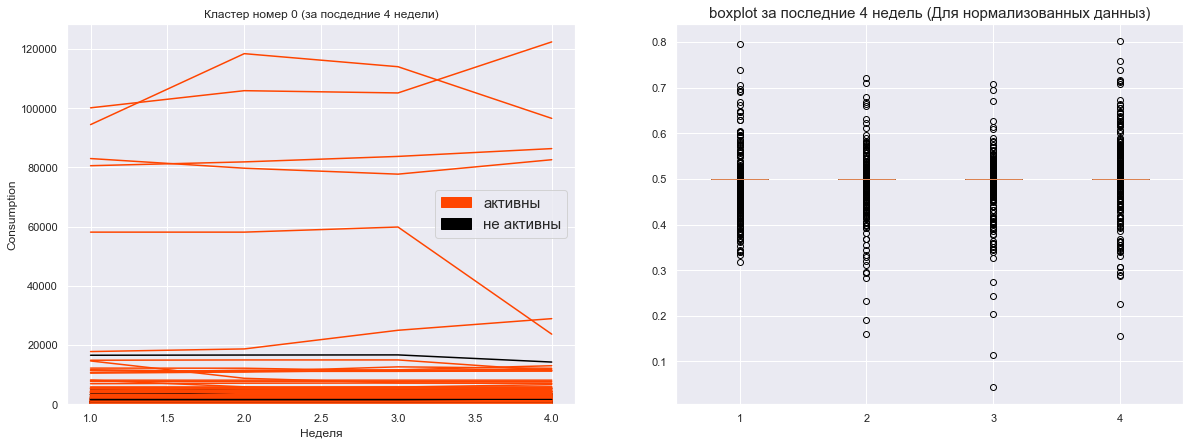

Количество id-ков: 25
Количество неактивных пользователей: 15
Количество активных пользователей: 10


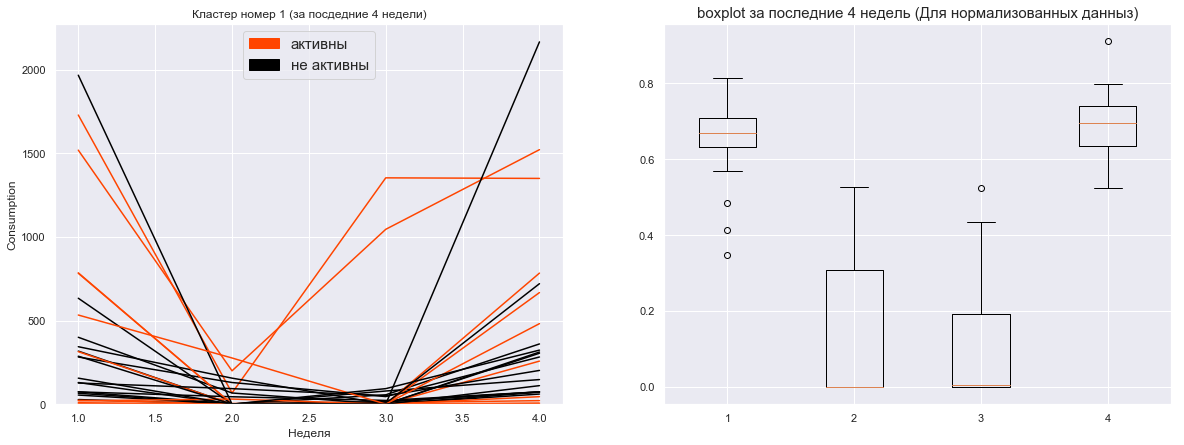

Количество id-ков: 84
Количество неактивных пользователей: 10
Количество активных пользователей: 74


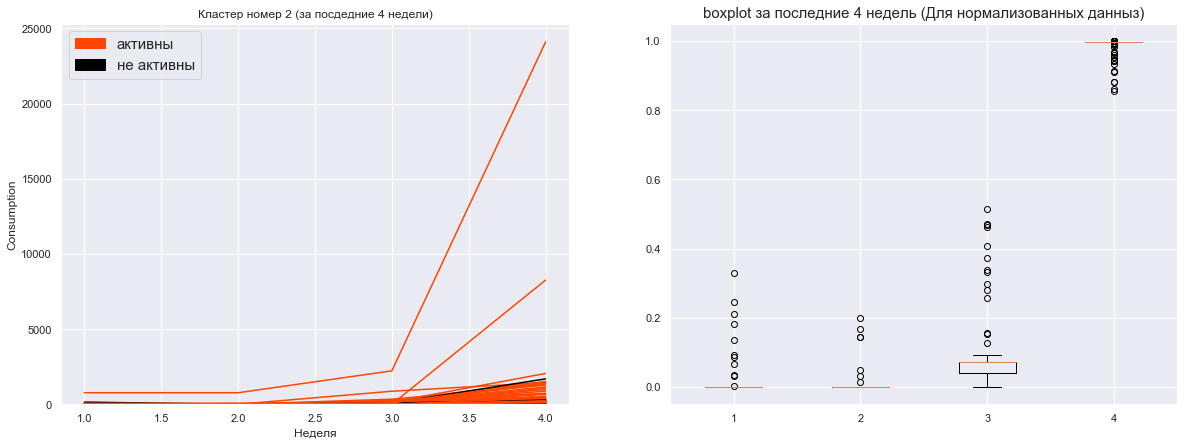

Количество id-ков: 41
Количество неактивных пользователей: 8
Количество активных пользователей: 33


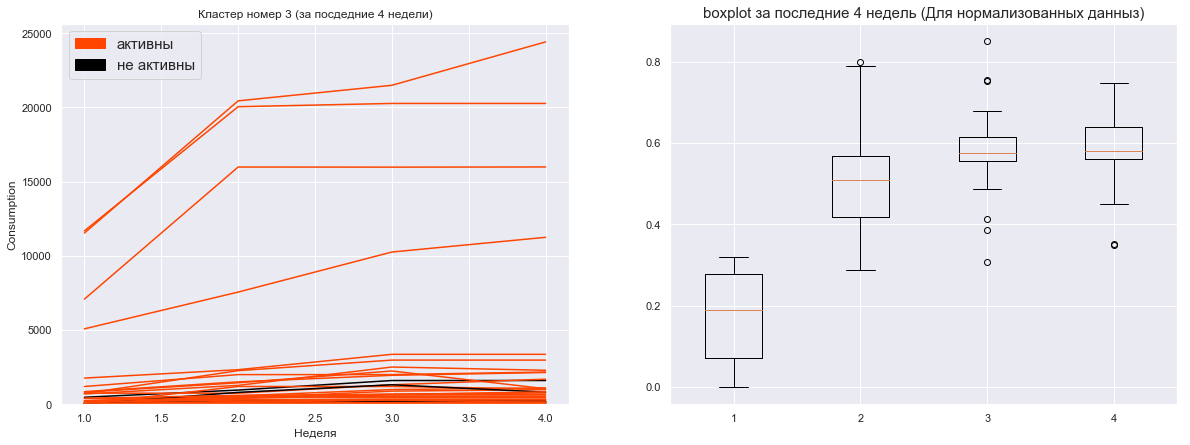

Количество id-ков: 23
Количество неактивных пользователей: 6
Количество активных пользователей: 17


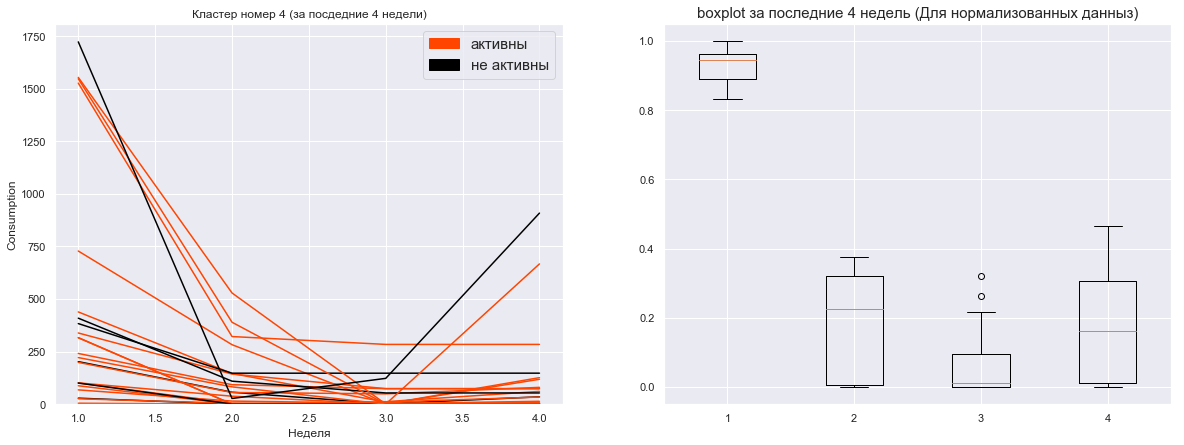

Количество id-ков: 18
Количество неактивных пользователей: 9
Количество активных пользователей: 9


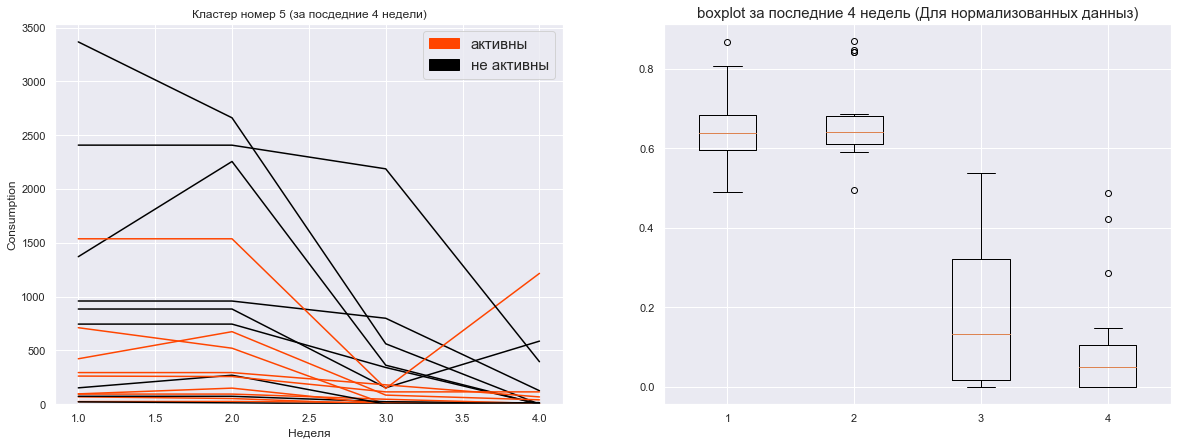

Количество id-ков: 29
Количество неактивных пользователей: 7
Количество активных пользователей: 22


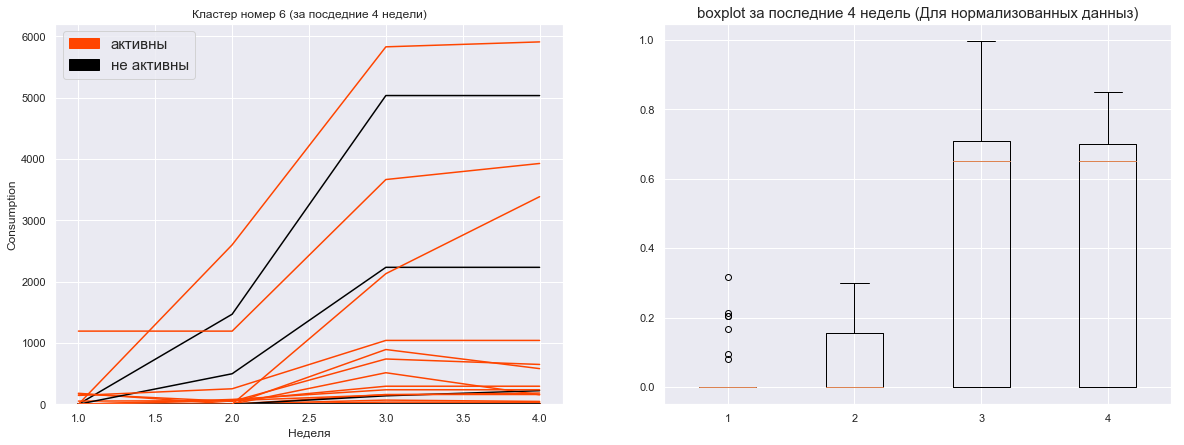

Количество id-ков: 8
Количество неактивных пользователей: 5
Количество активных пользователей: 3


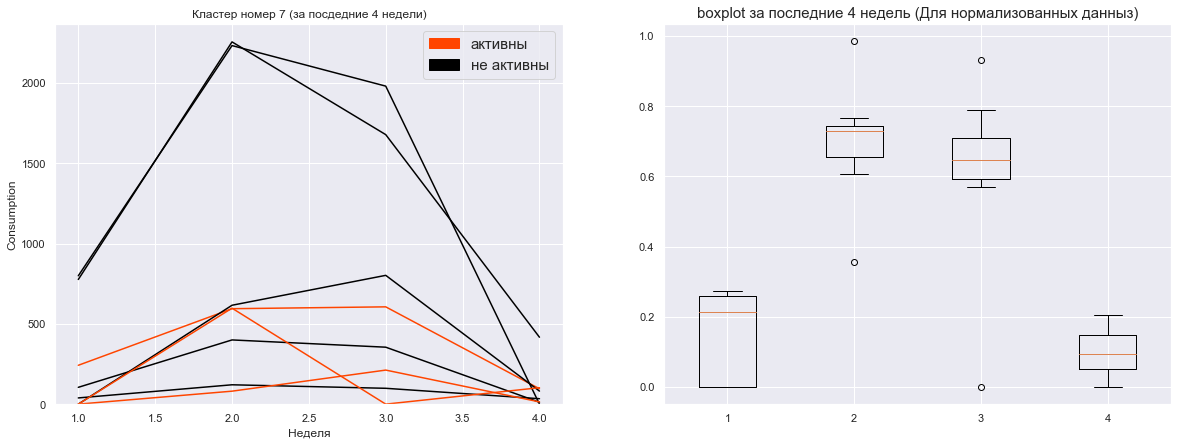

In [70]:
df_copy = compute_clustering_df.copy()
X, y = prepare_cluster_X_y(df_copy)
cluster_model.predict(X)
clusters = cluster_model.predict(X)
df_copy["clusters"] = clusters
print(X.shape)
for i in np.unique(clusters):
    show_cluster(i, df_copy, X, num_of_weeks_to_show = 4)

Как видим, в первом кластере также очень много активных пользователей.

In [71]:
compute_curr_df["clusters"] = clusters

In [72]:
from statsmodels.stats import multitest
def wald(n, m, p1, p2):
    sigma = np.sqrt(p1*(1 - p1) / n + p2 * (1 - p2) / m)
    return (p1 - p2) / sigma

def wald_test(X, Y):
    ans = sps.norm.cdf(wald(X.shape[0], Y.shape[0], np.mean(X), np.mean(y)))
    return ans

def two_sided_wald_test(X, Y):
    if wald_test(X, Y) < 0.05:
        return (True, wald_test(X, Y))
    if wald_test(Y, X) < 0.05:
        return (True, wald_test(Y, X))
    return False, min(wald_test(Y, X), wald_test(X, Y))

In [73]:
def in_cluster_compare(curr, min_days):
    cols = prepare_service_sku_columns(compute_curr_sku)
    unreal_cols = ["non_zero_days_" + col for col in cols]
    num = 0
    pval = []
    for col, name in zip(unreal_cols, cols):
        temp_1 = curr[curr[col] >  min_days]
        temp_2 = curr[curr[col] <=  min_days]
        if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
                continue
        num += 1
        X = np.array(temp_1["out_of_cloud"])
        Y = np.array(temp_2["out_of_cloud"])
        prin, res = two_sided_wald_test(X, Y)
        pval.append(res)
    
    #print(pval)
    h1, holm, _, _= multitest.multipletests(pval, method = 'holm')
    #print("FWER: answers:", h1, "Holms corrected p_val:", holm)
    plt.figure(figsize = (15, 20))
    ind = 1
    for col, name in zip(unreal_cols, cols):
        temp_1 = curr[curr[col] >  min_days]
        temp_2 = curr[curr[col] <=  min_days]
        if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
                continue
        X = np.array(temp_1["out_of_cloud"])
        Y = np.array(temp_2["out_of_cloud"])
        prin, res = two_sided_wald_test(X, Y)
        if h1[ind - 1]:
            print(name, "corrected p-val:", holm[ind - 1])
            print("num of use:", temp_1.shape[0])
            print("num of no use: ", temp_2.shape[0])
            print("================================")
            #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "black")
            plt.ylabel("Процент ушедших", fontsize = 15)
            ind += 1
        else:
            print(name, "corrected p-val:", holm[ind - 1])
            print("num of use:", temp_1.shape[0])
            print("num of no use: ", temp_2.shape[0])
            print("================================")
            #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "orangered")
            plt.ylabel("Процент ушедших", fontsize = 15)
            ind += 1
        #print("================================================================================================\n")
    plt.show()

In [74]:
def common_info_calc(df):
    numeric_cols = df.select_dtypes(include=[np.float64, np.float32, np.int64, np.int32]).columns
    category_cols = [i  for i in df.columns if i not in numeric_cols]
    pval = []
    num = 0
    for col in category_cols:
        if col == "out_of_cloud":
            continue
        for value in df[col].unique():
            if value == False:
                continue
            temp_1 = df[df[col] == value]
            temp_2 = df[df[col] !=  value]
            if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
                continue
            num += 1
            X = np.array(temp_1["out_of_cloud"])
            Y = np.array(temp_2["out_of_cloud"])
            prin, res = two_sided_wald_test(X, Y)
            pval.append(res)
    h1, holm, _, _= multitest.multipletests(pval, method = 'holm')
    ind = 1
    plt.figure(figsize = (20, 30))
    for col in category_cols:
        if col == "out_of_cloud":
            continue
        for i, value in enumerate(df[col].unique()):
            if value == False:
                continue
            temp_1 = df[df[col] == value]
            temp_2 = df[df[col] !=  value]
            if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
                continue
            X = np.array(temp_1["out_of_cloud"])
            Y = np.array(temp_2["out_of_cloud"])
            if value == True or value == False:
                name = col
            else:
                name = col + ":"+ value
                if "switzerland" in value:
                    name = col + ":" + "switz"
            if h1[ind - 1]:
                print(name, "corrected p-val:", holm[ind - 1])
                print("num of use:", temp_1.shape[0])
                print("num of no use: ", temp_2.shape[0])
                print("================================")
                #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
                plt.subplot((num + 1) // 2, 2, ind)
                plt.bar(["use_" + name, "no use_" + name], 
                        [np.mean(X) * 100, np.mean(Y) * 100], 
                        align='center', color = "black")
                plt.ylabel("Процент ушедших", fontsize = 15)
                ind += 1
            else:
                print(name, "corrected p-val:", holm[ind - 1])
                print("num of use:", temp_1.shape[0])
                print("num of no use: ", temp_2.shape[0])
                print("================================")
                #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
                plt.subplot((num + 1) // 2, 2, ind)
                plt.bar(["use_" + name, "no use_" + name], 
                        [np.mean(X) * 100, np.mean(Y) * 100], 
                        align='center', color = "orangered")
                plt.ylabel("Процент ушедших", fontsize = 15)
                ind += 1

Посмотрим, если ли влияние фичи на отток с помощью стат тестов. (Для 1 кластера и для всех кластеров целиком)

core_5.0 corrected p-val: 0.12270589174179161
num of use: 461
num of no use:  377
core_20.0 corrected p-val: 1.215223539312279e-09
num of use: 58
num of no use:  780
core_50.0 corrected p-val: 1.2946064012048703e-05
num of use: 40
num of no use:  798
core_100.0 corrected p-val: 0.12270589174179161
num of use: 400
num of no use:  438
platform_v1 corrected p-val: 7.569598985738779e-13
num of use: 652
num of no use:  186
platform_v2 corrected p-val: 9.250089073961642e-14
num of use: 256
num of no use:  582
subservice_windows corrected p-val: 0.12270589174179161
num of use: 154
num of no use:  684


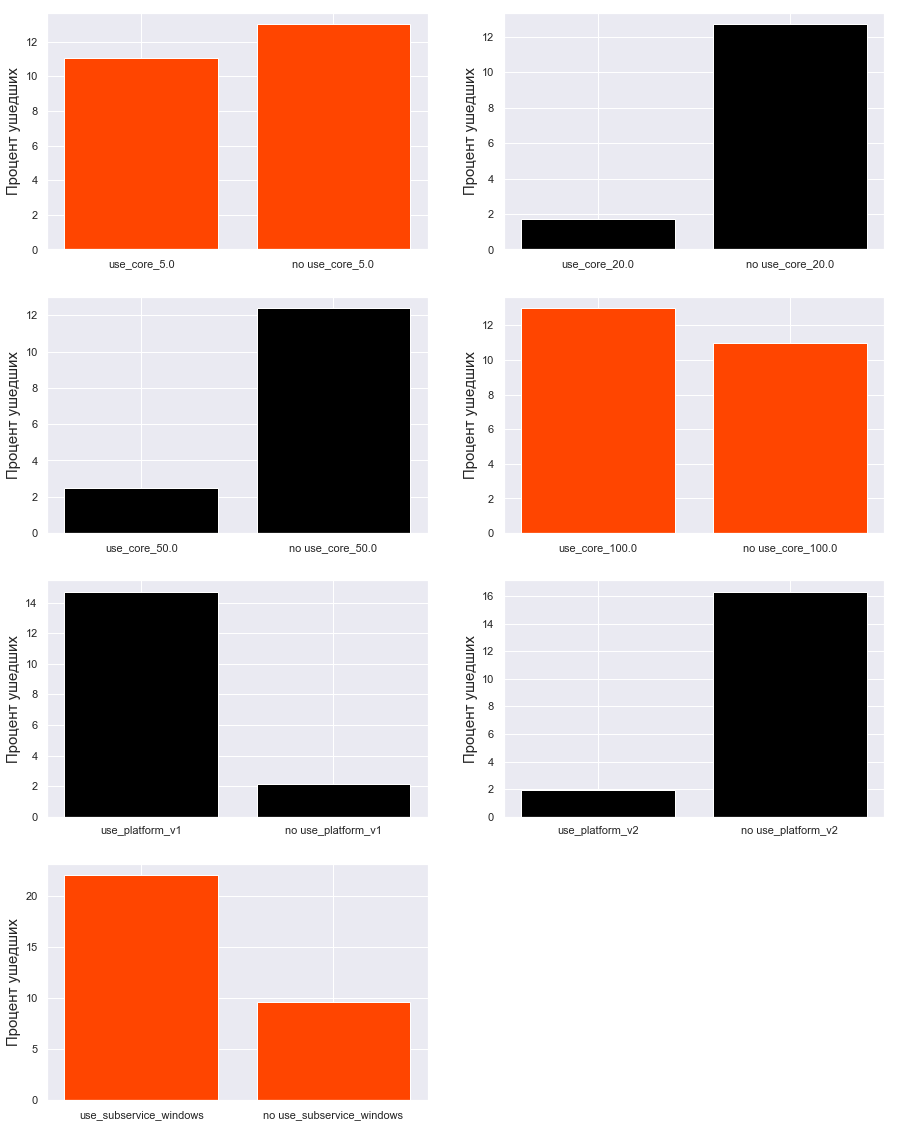

In [75]:
in_cluster_compare(compute_curr_df[compute_curr_df["clusters"] == 0], 20)

In [76]:
compute_person_df["was_call"] = compute_person_df["calls"] > 0
compute_person_df["was_visit"] = compute_person_df["visits"] > 0
compute_person_df["was_click"] = compute_person_df["clicks"] > 0
numeric_cols = compute_person_df.select_dtypes(include=[np.float64, np.float32, np.int64, np.int32]).columns
category_cols = [i  for i in compute_person_df.columns if i not in numeric_cols]
category_cols

['out_of_cloud',
 'ba_person_type',
 'segment',
 'ba_payment_cycle_type',
 'was_call',
 'was_visit',
 'was_click']

In [77]:
compute_curr_df = compute_person_df.copy()
compute_curr_df["clusters"] = clusters

ba_person_type:individual corrected p-val: 0.01067434201893859
num of use: 594
num of no use:  244
ba_person_type:company corrected p-val: 0.01067434201893859
num of use: 243
num of no use:  595
segment:mass corrected p-val: 0.0025029876850257227
num of use: 778
num of no use:  60
was_visit corrected p-val: 0.009674008514990203
num of use: 606
num of no use:  232
was_click corrected p-val: 0.0025029876850257227
num of use: 87
num of no use:  751


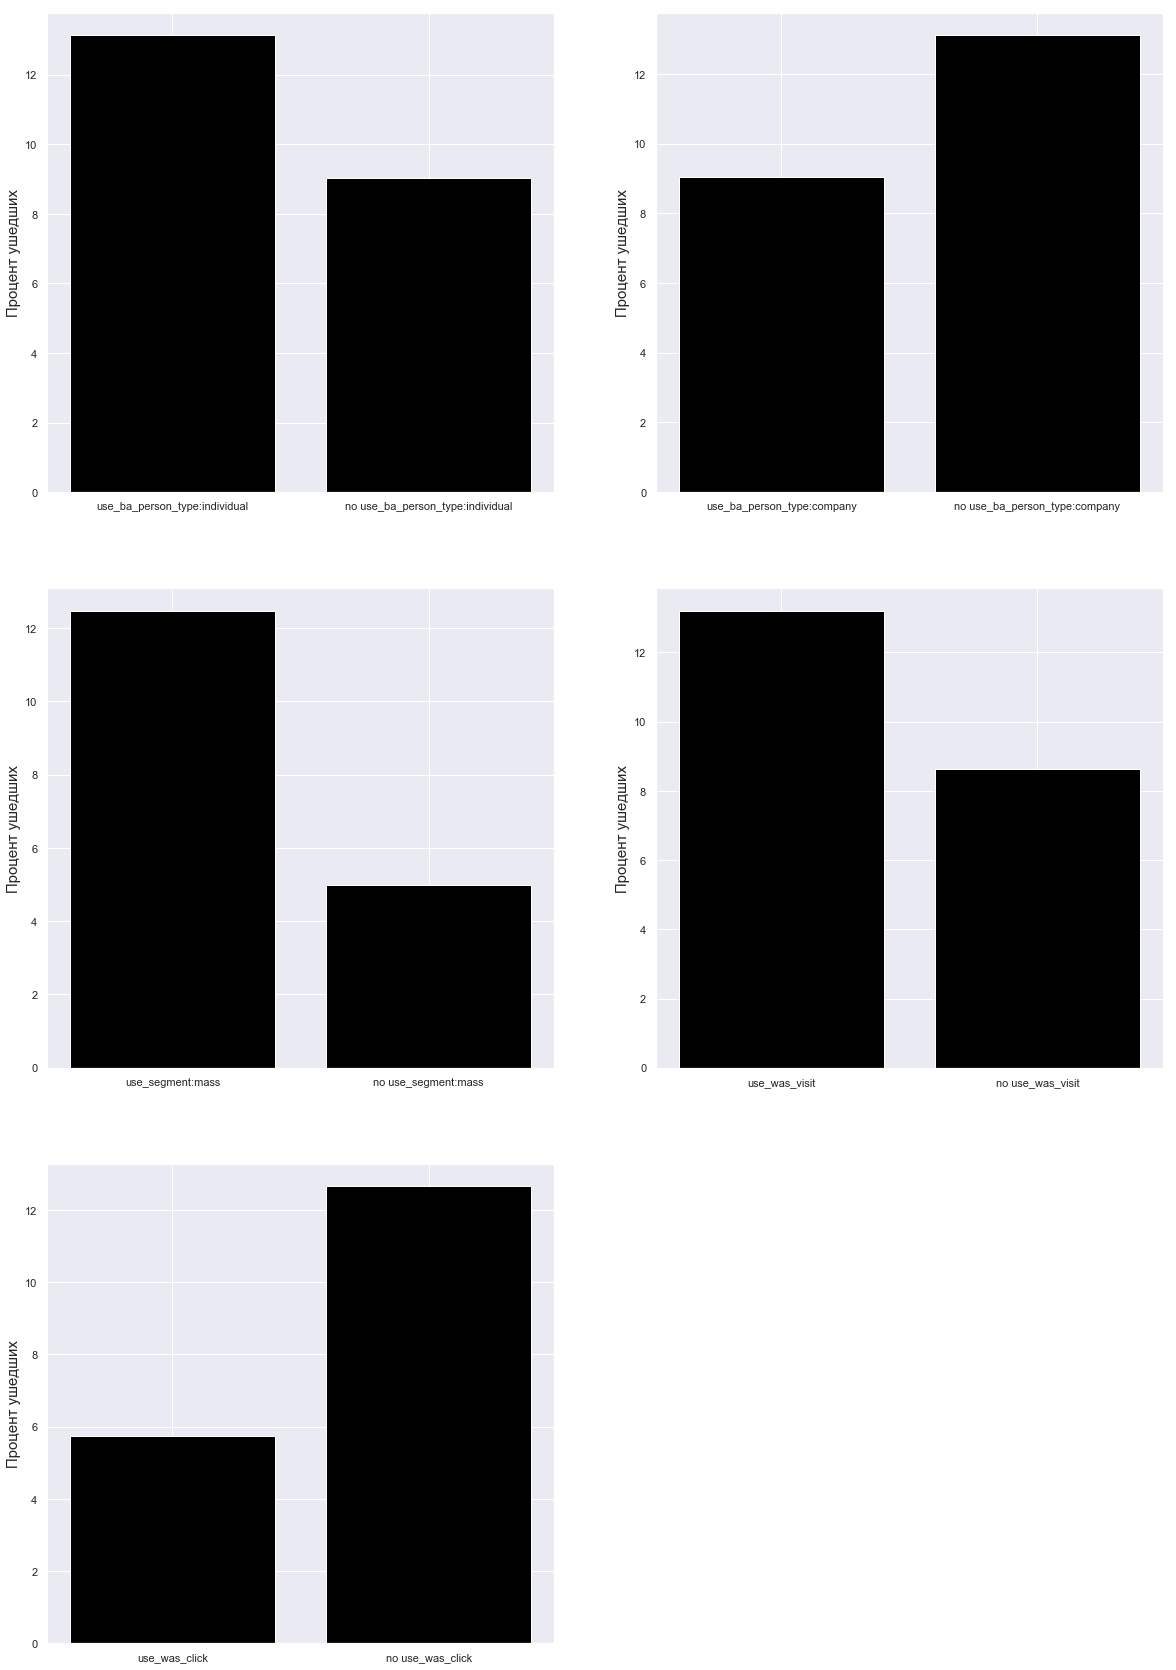

In [78]:
common_info_calc(compute_curr_df[compute_curr_df["clusters"] == 0])

---------------------------------

core_5.0 corrected p-val: 1.0
num of use: 528
num of no use:  538
core_20.0 corrected p-val: 6.774569203640644e-15
num of use: 77
num of no use:  989
core_50.0 corrected p-val: 2.055456338116952e-08
num of use: 51
num of no use:  1015
core_100.0 corrected p-val: 1.0
num of use: 457
num of no use:  609
platform_v1 corrected p-val: 0.0006413652454087765
num of use: 741
num of no use:  325
platform_v2 corrected p-val: 2.0659863468983172e-14
num of use: 306
num of no use:  760
subservice_cpu corrected p-val: 1.0
num of use: 946
num of no use:  120
subservice_ram corrected p-val: 1.0
num of use: 946
num of no use:  120
subservice_windows corrected p-val: 1.0
num of use: 180
num of no use:  886


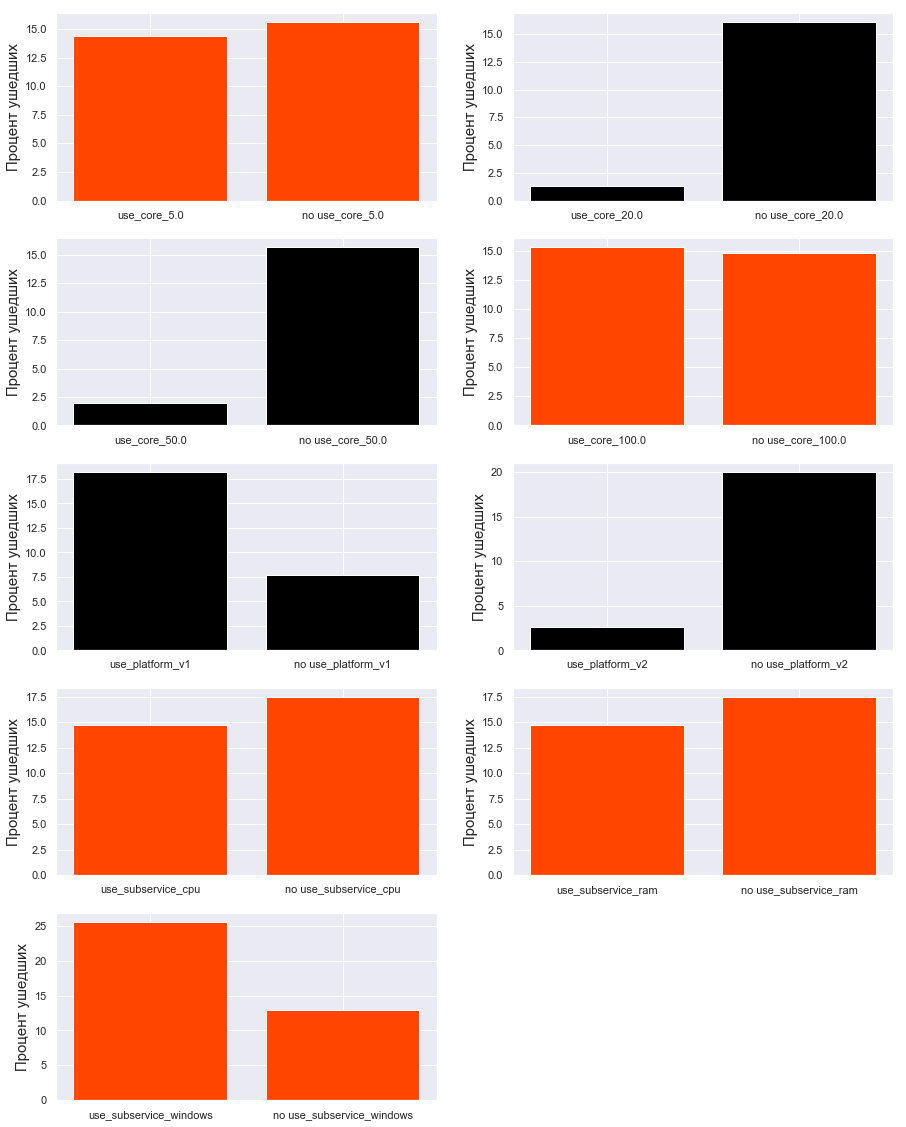

In [79]:
in_cluster_compare(compute_curr_df, 15)

Посмотрим, что будет, если уменьшим количество дней, когда фича должна быть активна.

core_5.0 corrected p-val: 0.6835099516484805
num of use: 602
num of no use:  464
core_20.0 corrected p-val: 2.735504383234705e-12
num of use: 100
num of no use:  966
core_50.0 corrected p-val: 1.3840174237884946e-10
num of use: 59
num of no use:  1007
core_100.0 corrected p-val: 0.6835099516484805
num of use: 508
num of no use:  558
platform_v1 corrected p-val: 9.77068956091113e-07
num of use: 808
num of no use:  258
platform_v2 corrected p-val: 8.519917320522714e-12
num of use: 379
num of no use:  687
preemtible_is corrected p-val: 0.015262931462406029
num of use: 39
num of no use:  1027
subservice_windows corrected p-val: 0.5517152019305785
num of use: 205
num of no use:  861


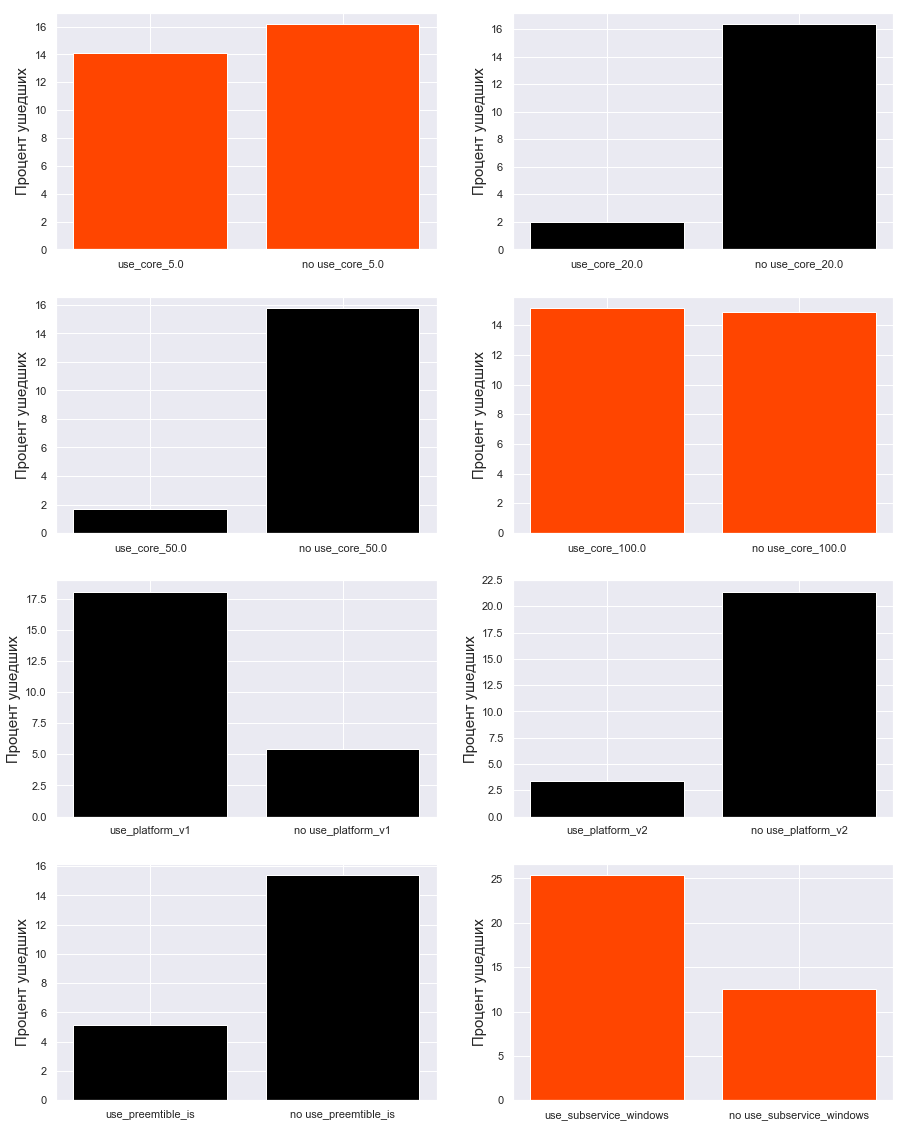

In [80]:
in_cluster_compare(compute_curr_df, 5)


Исходя из 2 представленных выше графиков, видно, что разница (существенная) есть для платформы (что я уже находил ранее), а также при использовании ядра на 20% и на 50%. Также прерывание влияет на активность.

In [81]:
compute_person_df["was_call"] = compute_person_df["calls"] > 0
compute_person_df["was_visit"] = compute_person_df["visits"] > 0
compute_person_df["was_click"] = compute_person_df["clicks"] > 0

In [82]:
compute_person_df["was_call"] = compute_person_df["calls"] > 0
compute_person_df["was_visit"] = compute_person_df["visits"] > 0
compute_person_df["was_click"] = compute_person_df["clicks"] > 0
numeric_cols = compute_person_df.select_dtypes(include=[np.float64, np.float32, np.int64, np.int32]).columns
category_cols = [i  for i in compute_person_df.columns if i not in numeric_cols]
category_cols

['out_of_cloud',
 'ba_person_type',
 'segment',
 'ba_payment_cycle_type',
 'was_call',
 'was_visit',
 'was_click']

ba_person_type:individual corrected p-val: 0.013901706346735465
num of use: 765
num of no use:  301
ba_person_type:company corrected p-val: 0.013901706346735465
num of use: 300
num of no use:  766
segment:mass corrected p-val: 1.3728021887258642e-05
num of use: 988
num of no use:  78
was_visit corrected p-val: 0.1390912826705486
num of use: 798
num of no use:  268
was_click corrected p-val: 0.4017955889608956
num of use: 120
num of no use:  946


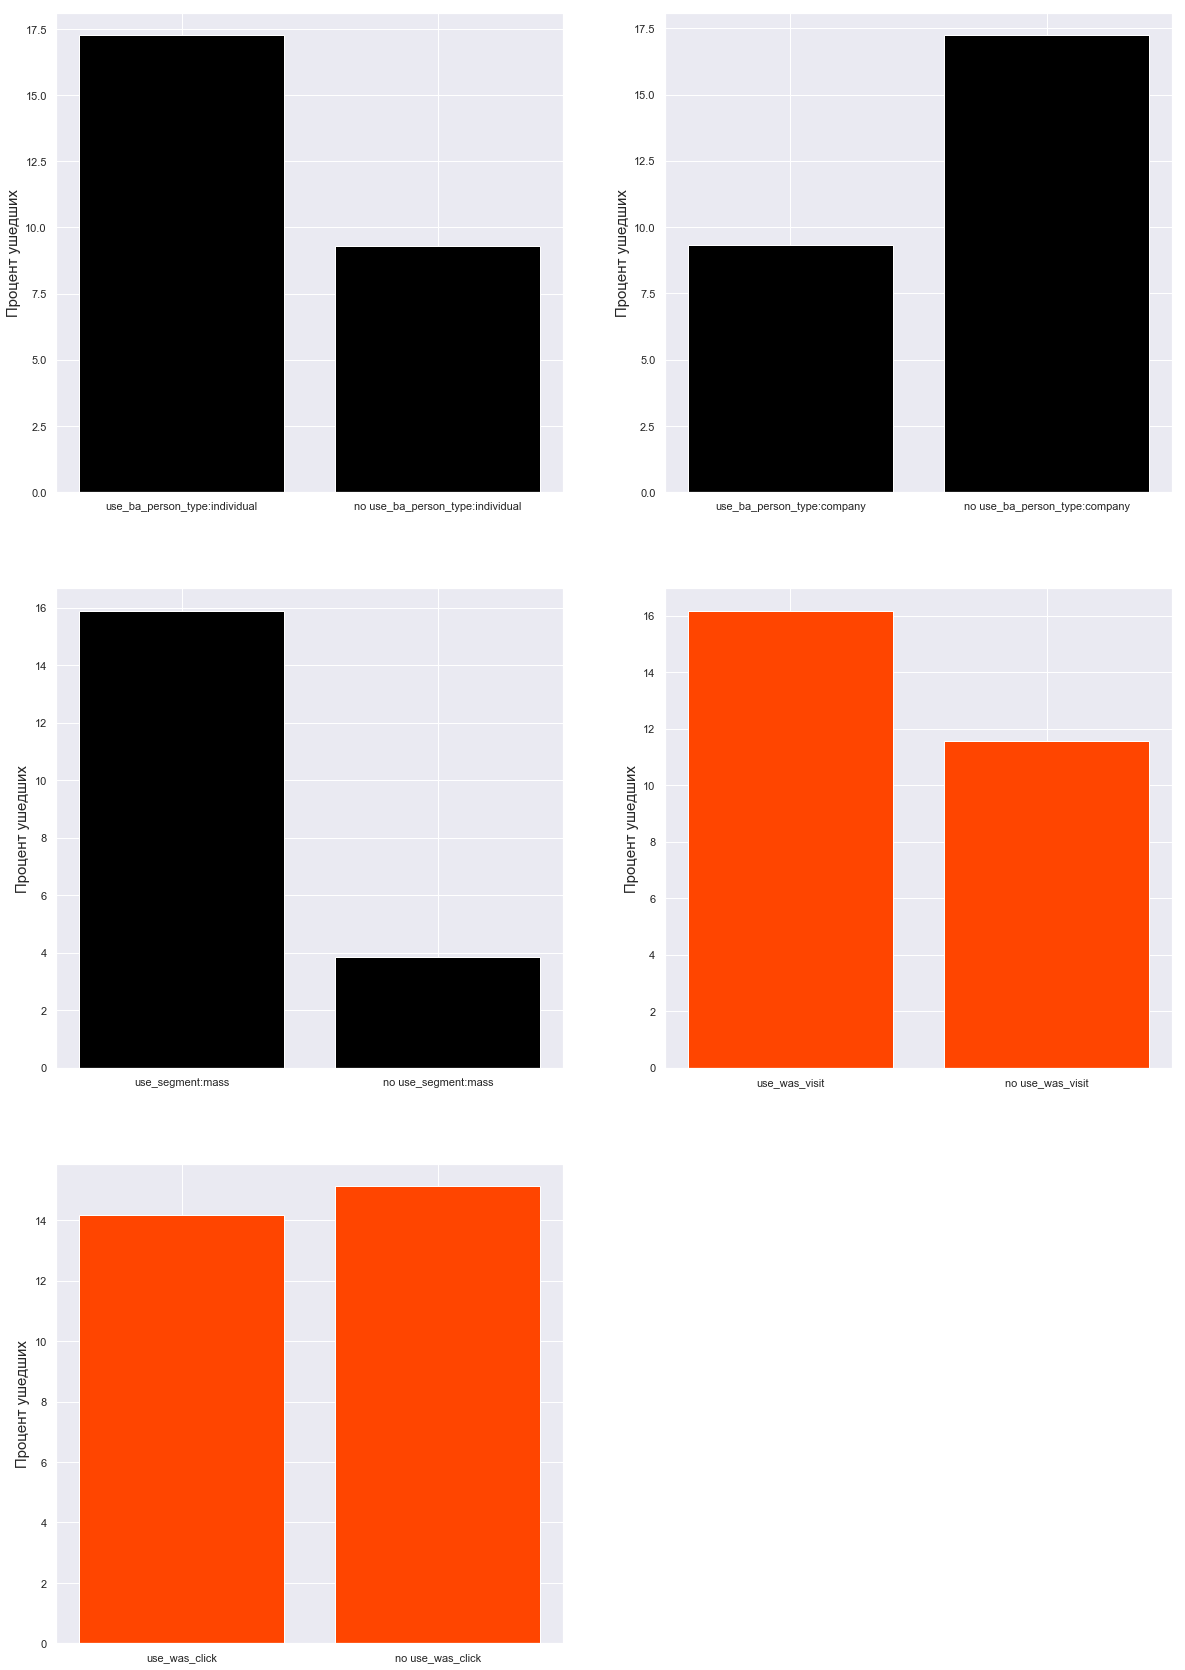

In [83]:
common_info_calc(compute_person_df)

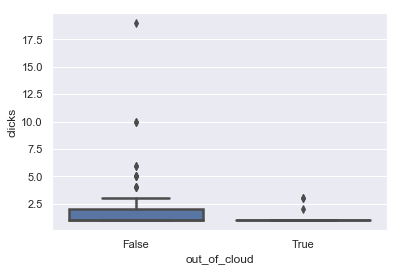

In [84]:
sns.boxplot(x="out_of_cloud", y="clicks", \
               data=compute_person_df[compute_person_df['clicks'] > 0], linewidth=2.5)

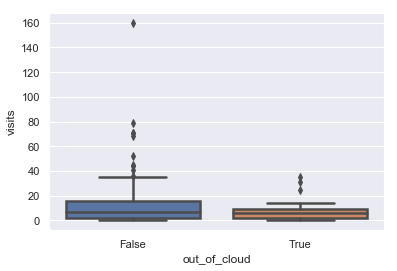

In [85]:
sns.boxplot(x="out_of_cloud", y="visits", \
               data=compute_person_df[compute_person_df['clicks'] > 0], linewidth=2.5)

## Использование network

In [86]:
network_curr_sku = "network"

In [87]:
network_hashed_clients = calculate_client_info(network_curr_sku, df)

Common info
unique users: (2970,)
OK


In [88]:
network_cols = prepare_service_sku_columns(network_curr_sku)

In [89]:
network_person_df = person_table_creator(network_curr_sku, df,\
                                            network_hashed_clients, network_cols, july)

Common info
unique users: 2970



Рассмотрено пользователей: 489
Ушло пользователей: 140
Процент ушедших пользователей: 0.28629856850715746


<Figure size 720x504 with 0 Axes>

In [90]:
compute_puid = compute_person_df["puid"].unique()

In [91]:
network_person_df = network_person_df[network_person_df["puid"].isin(compute_puid)]

In [92]:
network_person_df.shape

(429, 53)

In [93]:
def network_analysis_for_compute(min_days):
    cols = prepare_service_sku_columns(network_curr_sku)
    unreal_cols = ["non_zero_days_" + col for col in network_cols]
    num = 0
    pval = []
    for col, name in zip(unreal_cols, cols):
        temp_1_ids = network_person_df[network_person_df[col] >  min_days]["puid"].unique()
        temp_2_ids = network_person_df[network_person_df[col] <=  min_days]["puid"].unique()
        if temp_1_ids.shape[0] < 30 or temp_2_ids.shape[0] < 30:
            continue
        num += 1
        X = np.array(compute_person_df[compute_person_df["puid"].isin(temp_1_ids)]["out_of_cloud"])
        Y = np.array(compute_person_df[compute_person_df["puid"].isin(temp_2_ids)]["out_of_cloud"])
        prin, res = two_sided_wald_test(X, Y)
        pval.append(res)

    #print(pval)
    h1, holm, _, _= multitest.multipletests(pval, method = 'holm')
    #print("FWER: answers:", h1, "Holms corrected p_val:", holm)
    plt.figure(figsize = (16, 7))
    ind = 1
    for col, name in zip(unreal_cols, cols):
        temp_1_ids = network_person_df[network_person_df[col] >  min_days]["puid"].unique()
        temp_2_ids = network_person_df[network_person_df[col] <=  min_days]["puid"].unique()
        if temp_1_ids.shape[0] < 30 or temp_2_ids.shape[0] < 30:
            continue
        X = np.array(compute_person_df[compute_person_df["puid"].isin(temp_1_ids)]["out_of_cloud"])
        Y = np.array(compute_person_df[compute_person_df["puid"].isin(temp_2_ids)]["out_of_cloud"])
        prin, res = two_sided_wald_test(X, Y)
        if h1[ind - 1]:
            print(name, "corrected p-val:", holm[ind - 1])
            print("num of use:", temp_1_ids.shape[0])
            print("num of no use: ", temp_2_ids.shape[0])
            print("================================")
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "black")
            plt.ylabel("Процент ушедших", fontsize = 15)
            ind += 1
        else:
            print(name, "corrected p-val:", holm[ind - 1])
            print("num of use:", temp_1_ids.shape[0])
            print("num of no use: ", temp_2_ids.shape[0])
            print("================================")
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "orangered")
            plt.ylabel("Процент ушедших", fontsize = 15)
            ind += 1
        #print("================================================================================================\n")
    plt.show()

subservice_egress_inet corrected p-val: 0.015311138881753205
num of use: 327
num of no use:  102


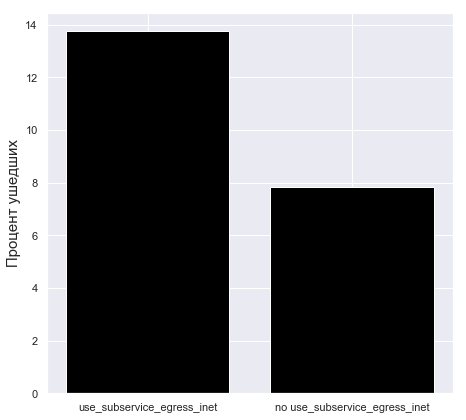

In [94]:
network_analysis_for_compute(10)

In [98]:
def in_cluster_compare(curr, min_days):
    cols = prepare_service_sku_columns(network_curr_sku)
    unreal_cols = ["non_zero_days_" + col for col in cols]
    num = 0
    pval = []
    for col, name in zip(unreal_cols, cols):
        temp_1 = curr[curr[col] >  min_days]
        temp_2 = curr[curr[col] <=  min_days]
        if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
                continue
        num += 1
        X = np.array(temp_1["out_of_cloud"])
        Y = np.array(temp_2["out_of_cloud"])
        prin, res = two_sided_wald_test(X, Y)
        pval.append(res)
    
    #print(pval)
    h1, holm, _, _= multitest.multipletests(pval, method = 'holm')
    #print("FWER: answers:", h1, "Holms corrected p_val:", holm)
    plt.figure(figsize = (15, 20))
    ind = 1
    for col, name in zip(unreal_cols, cols):
        temp_1 = curr[curr[col] >  min_days]
        temp_2 = curr[curr[col] <=  min_days]
        if temp_1.shape[0] < 30 or temp_2.shape[0] < 30:
                continue
        X = np.array(temp_1["out_of_cloud"])
        Y = np.array(temp_2["out_of_cloud"])
        prin, res = two_sided_wald_test(X, Y)
        if h1[ind - 1]:
            print(name, "corrected p-val:", holm[ind - 1])
            print("num of use:", temp_1.shape[0])
            print("num of no use: ", temp_2.shape[0])
            print("================================")
            #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "black")
            plt.ylabel("Процент ушедших", fontsize = 15)
            ind += 1
        else:
            print(name, "corrected p-val:", holm[ind - 1])
            print("num of use:", temp_1.shape[0])
            print("num of no use: ", temp_2.shape[0])
            print("================================")
            #print(temp_1.shape[0], np.sum(X), temp_2.shape[0], np.sum(Y))
            plt.subplot((num + 1) // 2, 2, ind)
            plt.bar(["use_" + name, "no use_" + name], 
                    [np.mean(X) * 100, np.mean(Y) * 100], 
                    align='center', color = "orangered")
            plt.ylabel("Процент ушедших", fontsize = 15)
            ind += 1
        #print("================================================================================================\n")
    plt.show()

In [100]:
network_person_df = person_table_creator(network_curr_sku, df,\
                                            network_hashed_clients, network_cols, july)

Common info
unique users: 2970



Рассмотрено пользователей: 489
Ушло пользователей: 140
Процент ушедших пользователей: 0.28629856850715746


<Figure size 720x504 with 0 Axes>

In [102]:
network_person_df.shape

(489, 53)

subservice_egress_inet corrected p-val: 0.9974403455759271
num of use: 373
num of no use:  116


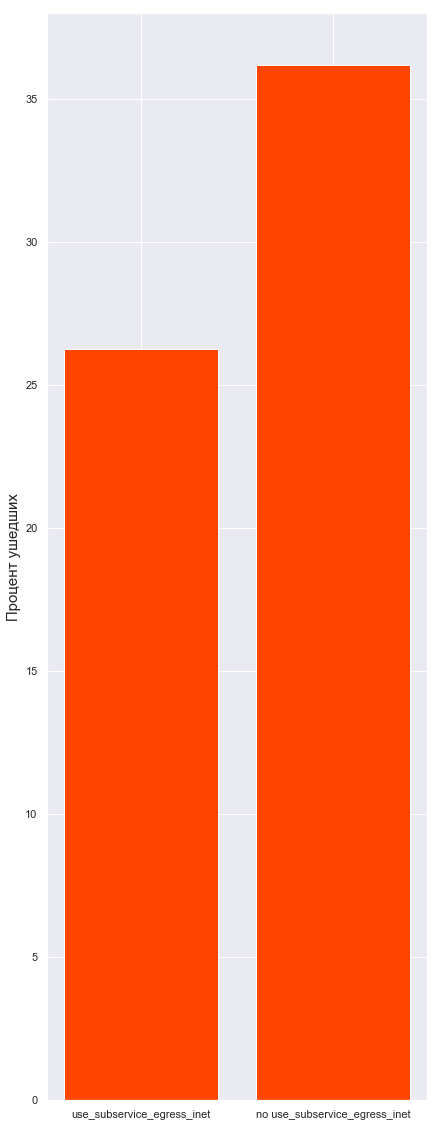

In [101]:
in_cluster_compare(network_person_df, 10)

## Вывод

По кластеризации стало понятно, что до того, как люди прекращают быть активными, они потребляют, в основном, одинаково каждую неделю. По кластеризации TSNE никаких выводов сделать не удалось. По кластеру, где клиенты потребляют примерно одинаково, статистически доказано, что влияют на отток `core_20.0, core_50.0, platform_v1, platform_v2`, а также тип ba_account(`individual, company`), `mass` сегмент, а также были ли в последние 30 дней клики или посещения сайта. Все отличия, кроме клик и и посещений, также статистически влияют на отток и в общем случае, поэтому,  про клики и посещения сайта стоит порассуждать отдельно. Также, если preemtible пишется только тогда, когда оно реально используется (не всегда для клиента, а только лишь в тот момент, когда действительно ядро прерывается), то preemtible также влияет на отток. В заключение, посмотрев на другие сервисы (а точнее только на network, так как по остальным данных мало), подтвердилось, что влияние `egress_inet` на отток также статистически значимо.
